<a href="https://www.kaggle.com/code/arthurirkaev/sf-dst-booking-reviews-project-3?scriptVersionId=126267419" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Импорт библиотек
Импортируем библиотеки и функции, которые планируем применять:

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install twython

# Визуализация данных
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# Работа с регулярными выражениями
import re
# Работа с координатами
from geopy.distance import geodesic as gd
# Анализ текста
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Кодирование категориальных признаков
import category_encoders as ce
# Оценка точности модели
from sklearn import metrics
# Нормализация числовых признаков
from sklearn import preprocessing
# Создание и обучение модели
from sklearn.ensemble import RandomForestRegressor
# Разделение датасета на train и test
from sklearn.model_selection import train_test_split

/kaggle/input/sentiment-words/negative-words.csv
/kaggle/input/sentiment-words/positive-words.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/list-of-countries/country_codes.csv


# Фиксация версии пакетов

In [2]:
!pip freeze > requirements.txt

# Константы
Задаем константы для использования и воспроизводимости эксперимента:
- **RANDOM_SEED** случайное начальное значение
- **TEST_SIZE** - объем части данных на валидацию
- **TARGET_NAME** - имя целевого столбца в наборе данных

In [3]:
RANDOM_SEED = 42
TEST_SIZE = 0.25
TARGET_NAME = 'reviewer_score'

# Подгрузка данных
Признаки:
- **hotel_address** - адрес отеля
- **review_date** - дата, когда рецензент разместил соответствующий отзыв.
- **average_score** - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- **hotel_name** - название отеля
- **reviewer_nationality** - национальность рецензента
- **negative_review** - отрицательный отзыв, который рецензент дал отелю.
- **review_total_negative_word_counts** - общее количество слов в отрицательном отзыв
- **positive_review** - положительный отзыв, который рецензент дал отелю
- **review_total_positive_word_counts** - общее количество слов в положительном отзыве
- **reviewer_score** - оценка, которую рецензент поставил отелю на основе своего опыта
- **total_number_of_reviews_reviewer_has_given** - количество отзывов, которые рецензенты дали в прошлом
- **total_number_of_reviews** - общее количество действительных отзывов об отеле
- **tags** - теги, которые рецензент дал отелю.
- **days_since_review** - продолжительность между датой проверки и датой очистки
- **additional_number_of_scoring** - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- **lat** - широта отеля
- **lng** - долгота отеля

In [4]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head(2)

reviewer_score      id
0               1  488440
1              10  274649

# Подготовка данных и проектирование признаков

# 1. Объединяем **df_train** и **df_test**
Для корректной обработки признаков объединяем датасеты **df_train** и **df_test**:

In [11]:
df_train['sample'] = 1 # помечаем датасет для обучения
df_test['sample'] = 0 # помечаем датасет для предсказания
df_test[TARGET_NAME] = 0 # в df_test у нас нет значения TARGET_NAME, по этому временно заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
data.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0             0.0  
1  52.385649  4.834443       0             0.0

# 2. Признак **hotel_address**

Оценим структуру написания адреса, выявим закономерности:

In [14]:
# для удобства при каждом запуске ячейки будут выводится случайные 5 адресов
random_id = np.random.randint(data.shape[0], size=5)
list(data.loc[random_id,'hotel_address'])

['Stadhouderskade 25 Oud Zuid 1071 ZD Amsterdam Netherlands',
 'Wagramer Stra e 16 18 22 Donaustadt 1220 Vienna Austria',
 '27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom',
 'South Quay Marsh Wall Tower Hamlets London E14 9SH United Kingdom',
 '18 Albert Embankment Lambeth London SE1 7TJ United Kingdom']

Структура написания адреса выглядит следующим образом:
1. Название улицы, номер дома (для **United Kingdom** и **France** - номер дома, название улицы)
2. Название района города
3. Индекс (для **United Kingdom** - Город) 
4. Город (для **United Kingdom** - Индекс)
5. Страна
* возможно отсутсвие 1-2 пунктов

## 2.1. Создадим признак **hotel_country**
Признак будет содержать название страны, в которой расположен отель:

In [15]:
# последнее слово в адресе - страна
# исключение United Kingdom - в названии два слова
data['hotel_country'] = data['hotel_address'].apply(
    lambda x: x.split(' ')[-1:][0]
    if x.split(' ')[-1:][0] != 'Kingdom'
    else x.split(' ')[-2:][0] + ' ' + x.split(' ')[-1:][0]
)

In [16]:
data['hotel_country'].value_counts(dropna = False)

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

## 2.2. Создадим признак **hotel_city**
Признак будет содержать название города, в котором расположен отель:

In [17]:
# предпоследнее слово в адресе - город
# исключение United Kingdom - между страной и городом
# находится индекс состоящий из двух слов
data['hotel_city'] = data['hotel_address'].apply(
    lambda x: x.split(' ')[-2:][0]
    if x.split(' ')[-1:][0] != 'Kingdom'
    else x.split(' ')[-5:][0]
)

In [18]:
data['hotel_city'].value_counts(dropna = False)

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

Для удобства дальнейшей работы сократим названия стран и городов используя аббревиатуры.

In [19]:
# словарь для переименования стран
abbreviate_countries = {
    'Austria':'AUT',
    'France':'FRA',
    'Italy':'ITA',
    'Netherlands':'NLD',
    'Spain':'ESP',
    'United Kingdom':'GBR'
}
data['hotel_country'] = data['hotel_country'].apply(lambda x: abbreviate_countries[x])

# словарь для переименования городов
abbreviate_citys = {
    'Amsterdam':'AMS',
    'Barcelona':'BCN',
    'London':'LND',
    'Milan':'ML',
    'Paris':'PA',
    'Vienna':'VI'
}
data['hotel_city'] = data['hotel_city'].apply(lambda x: abbreviate_citys[x])

In [20]:
data.groupby(['hotel_country', 'hotel_city'], as_index=False)['sample'].count()

hotel_country hotel_city  sample
0           AUT         VI   38939
1           ESP        BCN   60149
2           FRA         PA   59928
3           GBR        LND  262301
4           ITA         ML   37207
5           NLD        AMS   57214

В датасете представлено 6 городов из 6 стран (признаки коррелированы на 100%).

Cоздадим список **drop_list**, в который будем вносить имена признаков, которые собираемся удалять из финального датасета.

In [21]:
drop_list = list()

# добавим признак hotel_country в список на удаление из финального датасета
drop_list.extend(['hotel_country'])

Посмотрим на оценки рецензентов в разрезе городов:

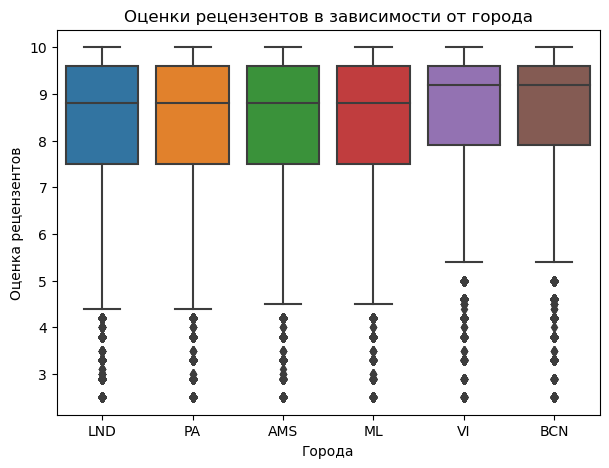

In [22]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='hotel_city',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от города')
plt.xlabel('Города')
plt.ylabel('Оценка рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

Учитывая, что значения признака влияют на оценку рецензентов, оставим признак для передачи в модель (далее будем придерживаться этого же принципа)

In [23]:
# количество отзывов по городам
data.query('sample == 1')['hotel_city'].value_counts(normalize=True)*100

LND    50.871891
BCN    11.667955
PA     11.589879
AMS    11.118321
VI      7.543375
ML      7.208579
Name: hotel_city, dtype: float64

## 2.3. Создадим признак **hotel_postcode**
Признак будет содержать почтовый индекс отеля, который хранит в себе информацию в том числе и о районе города.

У каждой из стран, представленных в датасете, определенные правила кодировки почтового индекса, ознакомимся с ними можно по ссылкам:

- [Austria (AUT)](https://postal-codes.cybo.com/austria/)
- [France (FRA)](https://postal-codes.cybo.com/france/)
- [Italy (ITA)](https://postal-codes.cybo.com/italy/)
- [Netherlands (NLD)](https://postal-codes.cybo.com/netherlands/)
- [Spain (ESP)](https://postal-codes.cybo.com/spain/)
- [United Kingdom (GBR)](https://postal-codes.cybo.com/united-kingdom/)

In [24]:
# зададим шаблоны для поиска индексов в hotel_address
postcode_dict = {
    'AUT':'\d{4}',
    'FRA':'\d{5}',
    'ITA':'\d{5}',
    'NLD':'\d{4}[ ][A-Z]{2}',
    'ESP':'\d{5}',
    'GBR':'[A-Z]{,2}\d{,2}[A-Z]{0,1}[ ]\d[A-Z]{2}'
}

data['hotel_postcode'] = data.apply(
    lambda x: re.search(postcode_dict[x['hotel_country']], x['hotel_address'])[0],
    axis=1
)

Посмотрим на зависимость средней оценки рецензента от индекса:

In [25]:
fig = px.histogram(
    data.query('sample == 1').groupby(['hotel_city', 'hotel_postcode'], as_index=False)['reviewer_score'].median(),
    x = 'hotel_postcode',
    y = 'reviewer_score',
    color = 'hotel_city'    
)
fig.update_layout(
    title='Медианная оценка рецензентов в зависимости от индекса',
    title_x = 0.5,
    xaxis_title='Индексы',
    yaxis_title='Медианная оценка',
    legend_title='Города'
)

Количество уникальных значений в признаке слищком велико, но можно с уверенностью сказать, что средняя оценка зависит от района города и признак полезен.

## 2.4. Создадим признак **hotel_borough**
Признак будет содержать информацию о районе города

Модифицируем индексы **Amsterdam** и **London** отбросив их вторую часть чтобы получить условное разделение на районы.

In [26]:
data['hotel_borough'] = data['hotel_postcode'].apply(
    lambda x: x.split(' ')[0]
)
data['hotel_borough'].nunique()

239

Уменьшим количество уникальных значений признака, сргуппируем индексы согласно следующим правилам:

In [27]:
rules_dict = {
    'AMS':'^\d{3}', # первые 3 цифры индекса
    'BCN':'^\d{4}', # первые 4 цифры индекса
    'LND':'^[A-Z]{1,2}\d{1,2}', # первые буквы и цифры индекса
    'ML':'^\d{4}', # первые 4 цифры индекса
    'PA':'^\d{5}', # без изменений
    'VI':'^\d{4}' # без изменений
}

data['hotel_borough'] = data.apply(
    lambda x: x['hotel_city'] +'_'+ re.match(rules_dict[x['hotel_city']], x['hotel_borough']).group(),
    axis=1
)

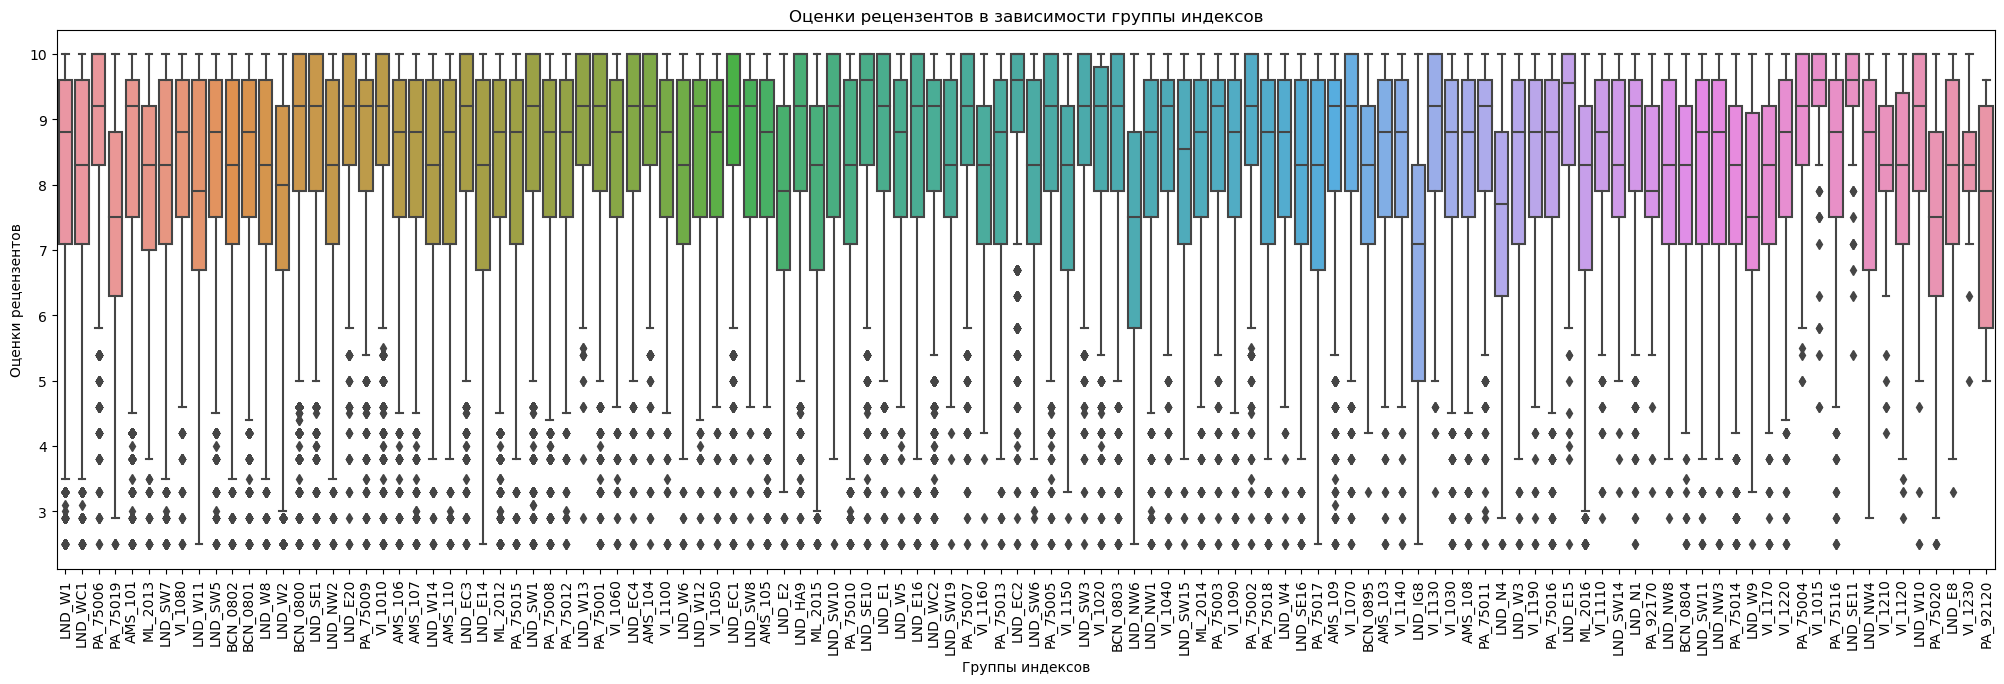

In [28]:
plt.figure(figsize=(25,7), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='hotel_borough',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости группы индексов')
plt.xlabel('Группы индексов')
plt.xticks(rotation=90)
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

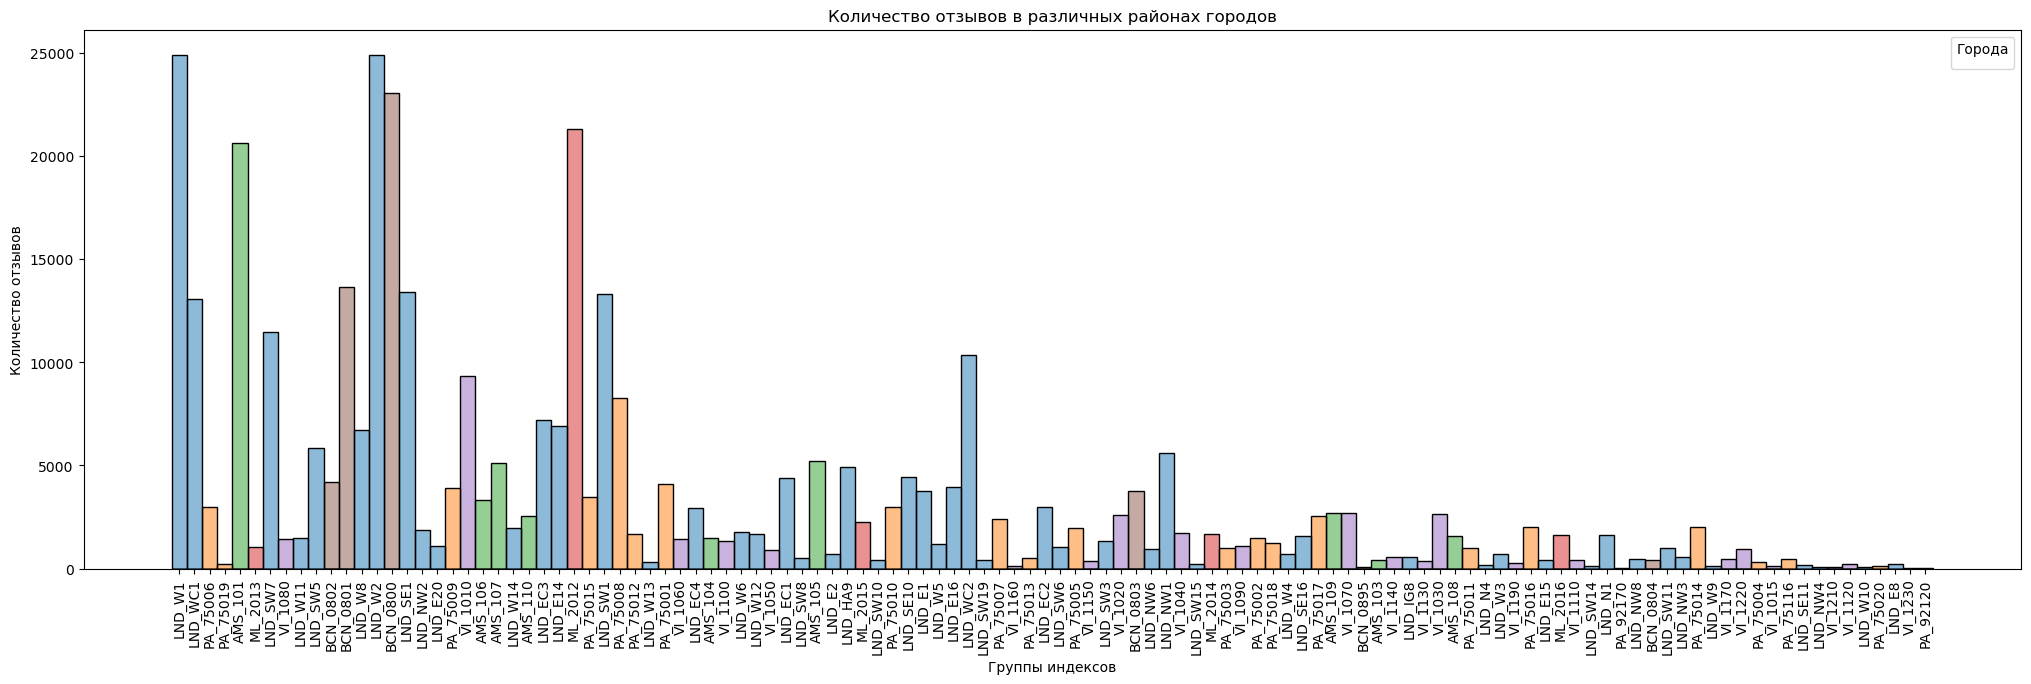

In [29]:
plt.figure(figsize=(25,7), dpi= 100)
sns.histplot(
    data=data.query('sample == 1'),
    x='hotel_borough',
    hue='hotel_city'
)
plt.title('Количество отзывов в различных районах городов')
plt.xlabel('Группы индексов')
plt.xticks(rotation=90)
plt.ylabel('Количество отзывов')
plt.legend(title='Города', loc='upper right')
plt.show()

Уникальных значений все еще много, так же остались районы в которых количество отзывов очень мало (фактически оня являются выбросами), однако оставим признак в таком виде.

In [30]:
# мы получили всю возможную информацию из признака hotel_address
# добавим его в список на удаление из финального датасета, а так же признак hotel_postcode
drop_list.extend(['hotel_address', 'hotel_postcode'])

# 3. Признаки **lat** и **lng**

Единственные признаки в которых были пропуски.

Сгруппируем пропуски в координатах **lat** и **lng** по названию отелей и городе расположения

In [31]:
lat_mask = data['lat'].isna()
lng_mask = data['lng'].isna()
data[lat_mask | lng_mask][['hotel_address', 'hotel_name', 'hotel_city']].value_counts()

hotel_address                                                hotel_name                                        hotel_city
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria  Fleming s Selection Hotel Wien City               VI            658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria          Hotel City Central                                VI            563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria     Hotel Atlanta                                     VI            389
4 rue de la P pini re 8th arr 75008 Paris France             Maison Albar Hotel Paris Op ra Diamond            PA            290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria       Hotel Daniel Vienna                               VI            245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria        Hotel Pension Baron am Schottentor                VI            223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria             Austria Trend Hotel Schloss Wilhelminenberg

В датасете отсутствует информация всего о 17 отелях.

Заполним данные вручную, используя словарь.
Можно было заполнить данные координат медианным значением для группы признаков **hotel_name** и **hotel_postcode**, но для большей точности отказался от этой идеи.

In [32]:
hotels_coordinates = {
    'Fleming s Selection Hotel Wien City':[
        48.20955191693932, 16.353402281386778
    ],
    'Hotel City Central':[
        48.213715657065485, 16.37990819672701
    ],
    'Hotel Atlanta':[
        48.22051044690924, 16.3558507832324
    ],
    'Maison Albar Hotel Paris Op ra Diamond':[
        48.87536666578755, 2.323424183266999
    ],
    'Hotel Daniel Vienna':[
        48.188868771763005, 16.38378456996825
    ],
    'Hotel Pension Baron am Schottentor':[
        48.21696399274972, 16.359894967892217
    ],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[
        48.219755228937096, 16.28563501206723
    ],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[
        48.2460444546301, 16.341810179543792
    ],
    'NH Collection Barcelona Podium':[
        41.39171699725171, 2.177904725225008
    ],
    'City Hotel Deutschmeister':[
        48.221146409604565, 16.366569575691894
    ],
    'Hotel Park Villa':[
        48.2337072603884, 16.345659739058046
    ],
    'Cordial Theaterhotel Wien':[
        48.20969186674418, 16.351474025561817
    ],
    'Holiday Inn Paris Montmartre':[
        48.88948766040316, 2.3332817441193736
    ],
    'Roomz Vienna':[
        48.186934439998616, 16.420739626141085
    ],
    'Mercure Paris Gare Montparnasse':[
        48.84014501714055, 2.3235067499726774
    ],
    'Renaissance Barcelona Hotel':[
        41.39360912038768, 2.1674844295105506
    ],
    'Hotel Advance':[
        41.38336726947921, 2.1629710540596254
    ]
}

# заполним пропуски
data.loc[lat_mask, 'lat'] = data[lat_mask]['hotel_name'].apply(
    lambda x: hotels_coordinates[x][0]
)
data.loc[lng_mask, 'lng'] = data[lng_mask]['hotel_name'].apply(
    lambda x: hotels_coordinates[x][1]
)

## 3.1. Создадим признак **distance**
Признак будет показывать расстояние от отеля до центра города.

In [33]:
# словарь с координатами центров (центральных площадей) городов
citys_coordinates = {
    'AMS':[
        52.373094699446945, 4.892650644182029
    ],
    'BCN':[
        41.38712798918705, 2.1700685352621862
    ],
    'LND':[
        51.501649751031685, -0.14188266273738495
    ],
    'ML':[
        45.46414293020246, 9.191925773054413
    ],
    'PA':[
        48.85334731799849, 2.3499283416536216
    ],
    'VI':[
        48.2085267134558, 16.373445089290655
    ]
}

# для ускорения расчетов создадим временный датасет с названиями отелей
# расчитаем расстояние до центра для каждого отеля и затем передадим эти данные
# в основной датасет
temp_df = data.groupby(['hotel_name', 'hotel_city', 'lat', 'lng'], as_index=False)['sample'].count()

temp_df.rename(columns={'sample':'distance'}, inplace=True)
temp_df['distance'] = temp_df.apply(
    lambda x: round(
        gd(
        (x['lat'], x['lng']), (citys_coordinates[x['hotel_city']])
        ).m
    ),
    axis=1
)

# объединим датасеты
data = data.merge(
    temp_df,
    how='left',
    on=['hotel_name', 'hotel_city', 'lat', 'lng']
)

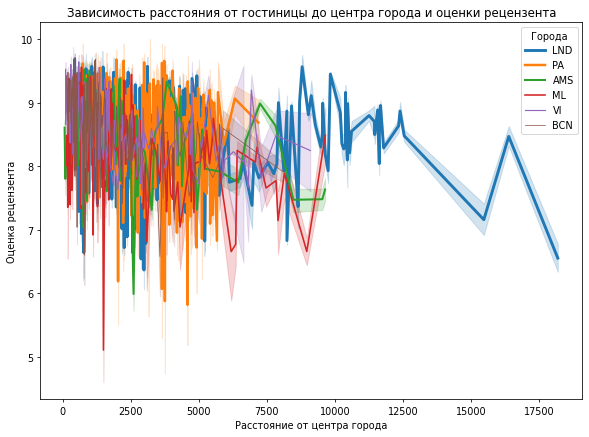

In [34]:
plt.figure(figsize=(10,7), dpi= 70)
sns.lineplot(
    data=data.query('sample == 1'),
    x='distance',
    y='reviewer_score',
    hue='hotel_city',
    size='hotel_city'
)
plt.title('Зависимость расстояния от гостиницы до центра города и оценки рецензента')
plt.xlabel('Расстояние от центра города')
plt.ylabel('Оценка рецензента')
plt.legend(title='Города')
plt.show()

Разброс значений очень большой, и значимость поолученного признака пока не ясна.

## 3.2. Создадим признак **distance_level**
Сгруппируем расстояния от гостиниц до центра города с шагом 500м и значениями признака от 1 до 11
- 1 - до 500м
- 2 - до 1000м
- ...
- 10 - до 5000м
- 11 - свыше 5000м

In [35]:
def distance_level(distance:int):
    '''
    Функция присваивает уровень в зависимости от дальности
    расположения гостиницы от центра города
    
    distance - дальность гостиницы от центра города
    '''
    n = 1 # начальный уровень
    distance_to_the_center = 500 # начальный критерий дальности
    while distance < 5000:
        if distance < distance_to_the_center:
            return n
        n += 1
        distance_to_the_center += 500
    return 11

data['distance_level'] = data['distance'].apply(distance_level)

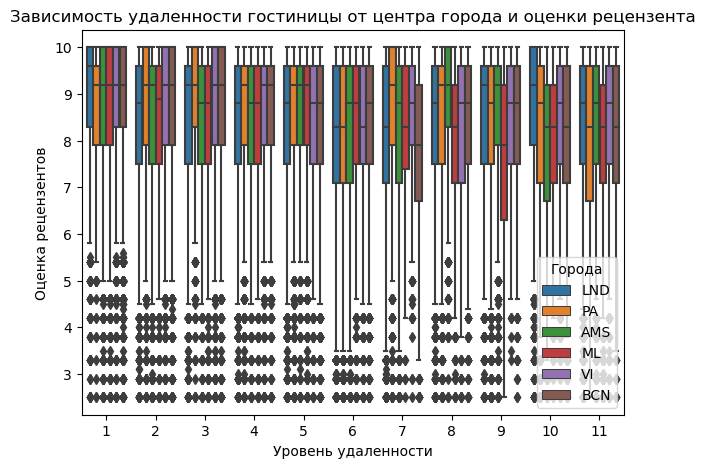

In [36]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='distance_level',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Зависимость удаленности гостиницы от центра города и оценки рецензента')
plt.xlabel('Уровень удаленности')
plt.ylabel('Оценка рецензентов')
plt.legend(
    loc='lower right',
    title='Города'
)
plt.show()

In [37]:
# мы получили всю возможную информацию из признаков lat и lng
# добавим их в список на удаление из финального датасета
drop_list.extend(['lat', 'lng'])

# 4. Признак **additional_number_of_scoring**

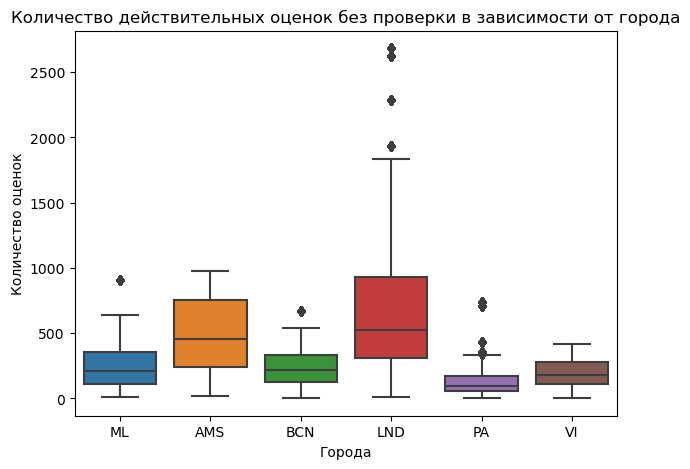

In [38]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data,
    x='hotel_city',
    y='additional_number_of_scoring'
)
plt.title('Количество действительных оценок без проверки в зависимости от города')
plt.xlabel('Города')
plt.ylabel('Количество оценок')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

# 5. Признак **review_date**

In [39]:
data['review_date'].tail(3)

515735     2/7/2016
515736    5/21/2017
515737     8/5/2016
Name: review_date, dtype: object

Признак содержит информацию о дате размещения отзыва в формате М/Д/Г

## 5.1. Создадим признаки **review_year**, **review_month**, **review_day** и **review_dayofweek**

In [40]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day'] = data['review_date'].dt.day
data['review_dayofweek'] = data['review_date'].dt.dayofweek

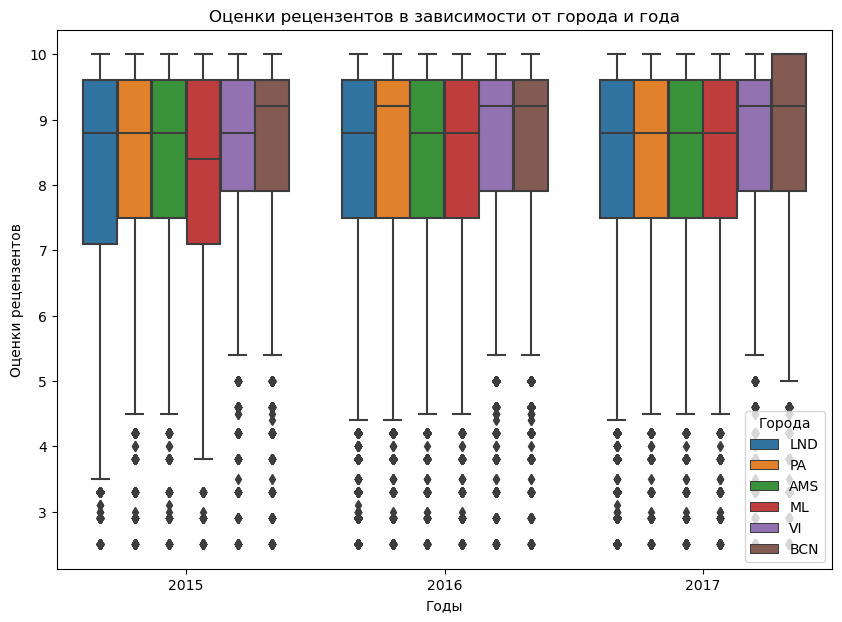

In [41]:
plt.figure(figsize=(10,7), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='review_year',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от города и года')
plt.xlabel('Годы')
plt.ylabel('Оценки рецензентов')
plt.legend(
    title='Города',
    loc='lower right'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

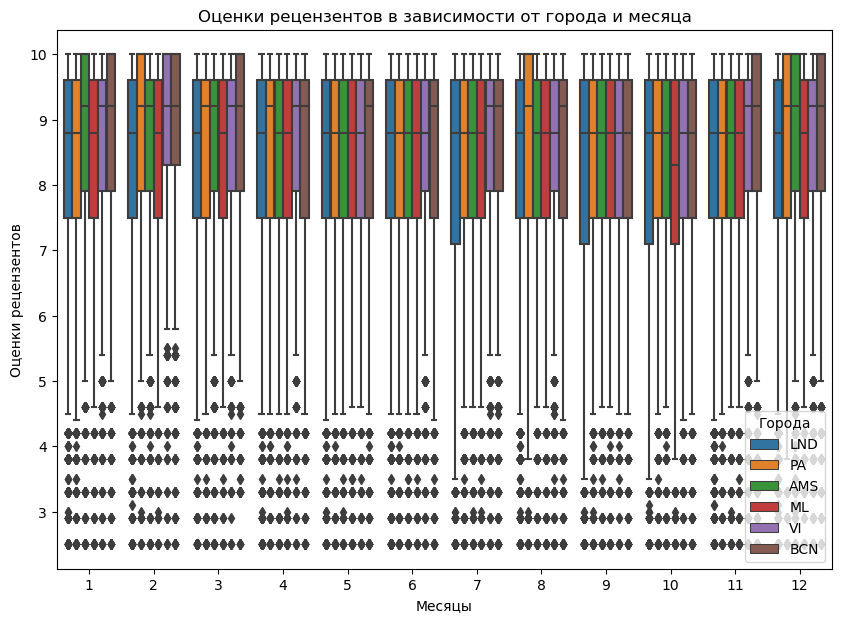

In [42]:
plt.figure(figsize=(10,7), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='review_month',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от города и месяца')
plt.xlabel('Месяцы')
plt.ylabel('Оценки рецензентов')
plt.legend(
    title='Города',
    loc='lower right'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

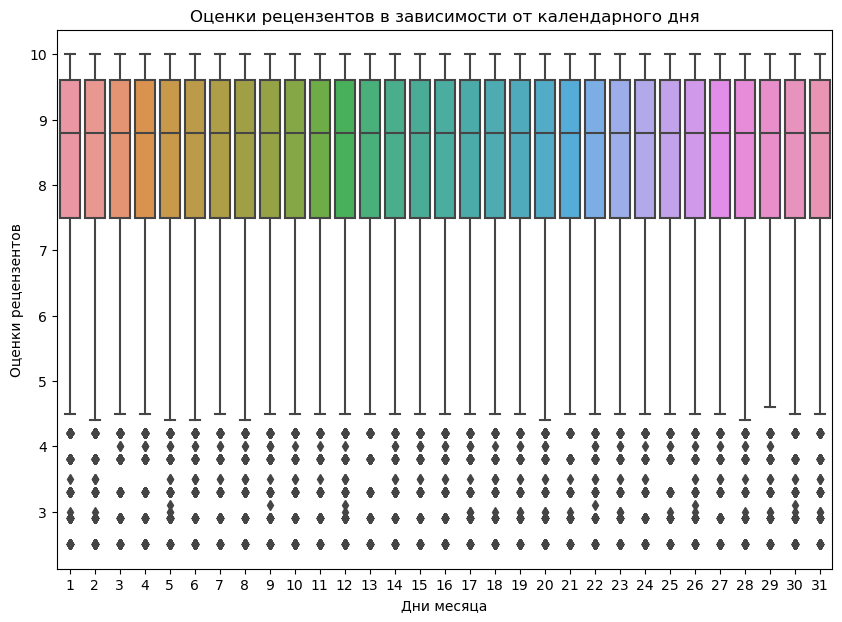

In [43]:
plt.figure(figsize=(10,7), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='review_day',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от календарного дня')
plt.xlabel('Дни месяца')
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что значимых различий нет

In [44]:
# добавим признак review_day в список на удаление из финального датасета
drop_list.extend(['review_day'])

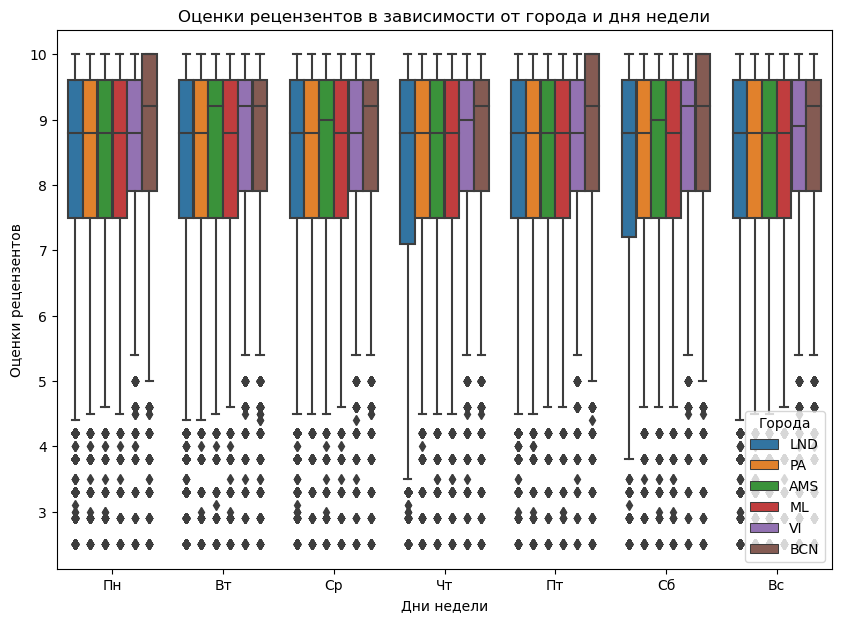

In [45]:
plt.figure(figsize=(10,7), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='review_dayofweek',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от города и дня недели')
plt.xlabel('Дни недели')
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
)
plt.ylabel('Оценки рецензентов')
plt.legend(
    title='Города',
    loc='lower right'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [46]:
# мы получили всю возможную информацию из признака review_date
# добавим признак review_date в список на удаление из финального датасета
drop_list.extend(['review_date'])

# 6. Признак **average_score**

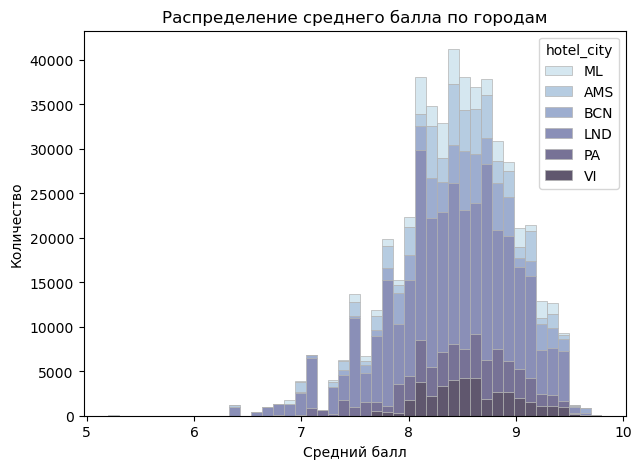

In [47]:
plt.figure(figsize=(7,5), dpi= 100)
sns.histplot(
    data=data,
    x='average_score',
    hue='hotel_city',
    multiple='stack',
    palette='ch:s=.25,rot=-.25',
    edgecolor='.7',
    linewidth=.5,
    bins=45
)
plt.title('Распределение среднего балла по городам')
plt.xlabel('Средний балл')
plt.ylabel('Количество')
#plt.legend(title='Города')
plt.show()

# 7. Признак **hotel_name**

In [48]:
data['hotel_name'].value_counts().index[:15]

Index(['Britannia International Hotel Canary Wharf', 'Strand Palace Hotel',
       'Park Plaza Westminster Bridge London',
       'Copthorne Tara Hotel London Kensington',
       'DoubleTree by Hilton Hotel London Tower of London',
       'Grand Royale London Hyde Park', 'Holiday Inn London Kensington',
       'Hilton London Metropole', 'Millennium Gloucester Hotel London',
       'Intercontinental London The O2', 'Park Grand Paddington Court',
       'Hilton London Wembley', 'Park Plaza County Hall London',
       'Blakemore Hyde Park', 'Park Plaza London Riverbank'],
      dtype='object')

В датасете присутсвуют сетевые гостиницы, попробуе их найти.

## 7.1. Создадим признак **hotel_network**

In [49]:
# словарь с названиями сетей гостиниц и их брендами
hotels_chains = {
    'Marriott International':[
        'Ritz-Carlton', 'St. Regis', 'JW Marriott', 'Luxury Collection',
        'W ', 'EDITION', 'Marriott', 'Sheraton', 'Delta', 'Le Meridien',
        'Westin', 'Renaissance', 'Gaylord', 'Courtyard', 'Four Points',
        'SpringHill', 'Protea', 'Fairfield Inn', 'AC ', 'Aloft', 'Moxy',
        'Residence Inn', 'TownePlace', 'element', 'Homes & Villas',
        'Autograph Collection', 'Design Hotels', 'Tribute Portfolio'
    ],
    
    'Hilton Hotels & Resorts':[
        'Canopy', 'Conrad', 'Curio', 'Doubletree by Hilton', 'Embassy Suites',
        'Hampton by Hilton', 'Hilton', 'Hilton Garden Inn', 'Hilton Grand Vacations',
        'Home2 Suites', 'Homewood Suites', 'LXR', 'Motto', 'Signia', 'Tapestry',
        'Tempo', 'Tru', 'Waldorf Astoria'
    ],
     
    'Wyndham Hotels & Resorts': [
        'AmericInn', 'Baymont', 'Caesars Rewards', 'Days Inn', 'Dazzler',
        'Dolce Hotels & Resorts', 'Esplendor', 'Hawthorn Suites',
        'Howard Johnson', 'La Quinta', 'Microtel', 'Ramada', 'Super 8',
        'Trademark Collection', 'Travelodge', 'TRYP', 'Wingate', 'Wyndham',
        'Wyndham Garden', 'Wyndham Grand', 'Wyndham Vacation Clubs',
        'Registry Collection', 'Wyndham Alltra' , 'Vienna House'
    ],
        
    'InterContinental Hotels Group':[
        'Six Senses', 'Regent', 'InterContinental', 'Vignette Collection',
        'Kimpton', 'Hotel Indigo', 'voco', 'HUALUXE', 'Crowne Plaza',
        'Iberostar', 'EVEN', 'Holiday Inn', 'avid', 'Atwell', 'Staybridge' ,'Candlewood'
    ],
    
    'Accor Hotels':[
        'Raffles', 'Orient Express', 'Faena', 'Banyan Tree', 'Delano',
        'Sofitel Legend', 'Fairmont', 'EMBLEMS', 'SLS', 'SO/', 'Sofitel',
        'Rixos', 'onefinestay', 'Mantis', 'MGallery', '21c Museum',
        'Art Series', 'Mondrian', 'Pullman', 'Swissotel', '25hours',
        'Angsana', 'Mövenpick', 'Peppers', 'The Sebel', 'Adagio', 'Mantra',
        'Novotel', 'Mercure', 'Mama Shelter', 'TRIBE', 'Breakfree', 'ibis',
        'greet', 'JO&JOE', 'hotelF1', 'Thalassa', 'Handwritten', 'The Hoxton'
    ],
    
    'Hyatt Hotels Corporation':[
        'Hyatt', 'UrCove', 'Miraval', 'Alila', 'Andaz', 'Thompson'
    ],
    
    'Radisson Hotel Group':[
        'Radisson Collection', 'Radisson Blu', 'Radisson', 'Radisson RED',
        'Radisson Individuals', "art'otel", 'Park Plaza', 'Park Inn',
        'Country Inn & Suites', 'prizeotel'
    ],
    
    'Louvre Hotels Group':[
        'Royal Tulip', 'TemptingPlaces', 'Hotels & Preference', 'Golden Tulip', 'Sarovar',
        'Campanile', 'Tulip Residences', 'Tulip Inn', 'Kyriad', 'Premiere Classe'
    ]
    
}

In [50]:
def hotel_in_the_chain(hotel_name:str):
    '''
    Функция определяет принадлежность отеля к сети
    
    hotel_name - название отеля
    '''
    for chain in hotels_chains:
        for name in hotels_chains[chain]:
            if name in hotel_name:
                return 1
    return 0

data['hotel_network'] = data['hotel_name'].apply(hotel_in_the_chain)

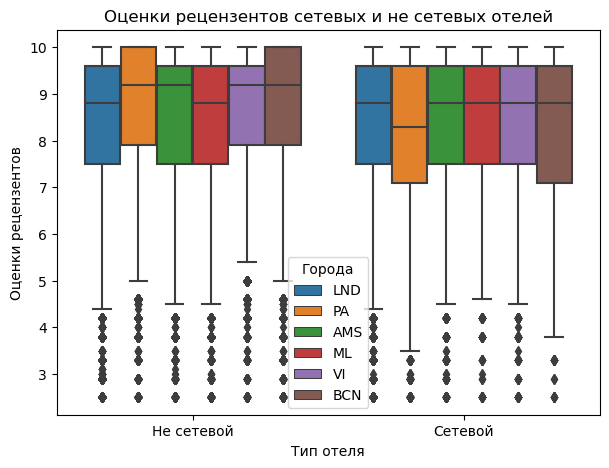

In [51]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='hotel_network',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов сетевых и не сетевых отелей')
plt.xlabel('Тип отеля')
plt.xticks(
    [0, 1],
    ['Не сетевой', 'Сетевой']
)
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower center',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [52]:
# мы получили всю возможную информацию из признака hotel_name
# добавим его в список на удаление из финального датасета
drop_list.extend(['hotel_name'])

# 8. Признак **reviewer_nationality**

In [53]:
data['reviewer_nationality'].head(3)

0     United Kingdom 
1            Belgium 
2             Sweden 
Name: reviewer_nationality, dtype: object

Признак содержит информацию о национальности рецензента, для удобства дальнейшей работы сократим названия страны используя общепринятые аббревиатуры (аналагично сокращению названия страны для **hotel_country**).

Источник инорфмации о странах: [Kaggle user **krazydawg**](https://www.kaggle.com/datasets/statchaitya/country-to-continent)

In [54]:
# подгружаем датасет
country_codes = pd.read_csv('/kaggle/input/list-of-countries/country_codes.csv')
country_codes.head(3)

country code_2 code_3  country_code     iso_3166_2 continent  \
0   Afghanistan     AF    AFG             4  ISO 3166-2:AF      Asia   
1  land Islands     AX    ALA           248  ISO 3166-2:AX    Europe   
2       Albania     AL    ALB             8  ISO 3166-2:AL    Europe   

        sub_region  region_code  sub_region_code  
0    Southern Asia        142.0             34.0  
1  Northern Europe        150.0            154.0  
2  Southern Europe        150.0             39.0

In [55]:
# удаляем пробельные символы в начале и конце reviewer_nationality
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [56]:
# объединяем датасеты по национальности рецензента
data = data.merge(
    country_codes[['country', 'code_3']],
    how='left',
    left_on='reviewer_nationality',
    right_on='country',
    suffixes=(False, False)
)

Проверим, есть ли национальности, названия которых не совпали с **country_codes**.

In [57]:
data[data['code_3'].isna()]['reviewer_nationality'].value_counts()

United Kingdom                      245246
Russia                                3900
Iran                                  1086
South Korea                           1078
Taiwan                                 923
                                       523
Macedonia                              282
Vietnam                                187
Abkhazia Georgia                       153
Macau                                  109
Moldova                                108
Brunei                                 100
Venezuela                               78
Kosovo                                  72
Tanzania                                58
Palestinian Territory                   54
Cura ao                                 41
Syria                                   33
Ivory Coast                             19
Bolivia                                 18
U S Virgin Islands                      17
British Virgin Islands                  16
Antigua Barbuda                         14
Turks Caico

Отдельно проверим "пустые" значения 

In [58]:
data[data['reviewer_nationality'] == ''].head(3)

hotel_address  \
125   47 Welbeck Street Westminster Borough London W...   
1105  Prinses Irenestraat 30 Zuideramstel 1077 WX Am...   
1160  Aletta Jacobslaan 7 Slotervaart 1066 BP Amster...   

      additional_number_of_scoring review_date  average_score  \
125                            411  2016-10-27            8.9   
1105                           726  2017-04-24            8.6   
1160                           555  2016-12-19            8.4   

                             hotel_name reviewer_nationality  \
125                The Marylebone Hotel                        
1105                 citizenM Amsterdam                        
1160  Corendon Vitality Hotel Amsterdam                        

                                        negative_review  \
125    The room was luxurious and met my every need ...   
1105   The sheer curtain that you can pull between t...   
1160                                           Location   

      review_total_negative_word_counts  total_number_of_reviews  \
125                                  16                     1738   
1105                                171                     4530   
1160                                  2                     4410   

                                        positive_review  ...  hotel_borough  \
125    I enjoyed the whole experience it was a luxur...  ...         LND_W1   
1105   The bed was giant and quite comfortable The r...  ...        AMS_107   
1160                                        Cleanliness  ...        AMS_106   

      distance distance_level review_year  review_month  review_day  \
125       1908              4        2016            10          27   
1105      3648              8        2017             4          24   
1160      5123             11        2016            12          19   

      review_dayofweek  hotel_network country code_3  
125                  3              0     NaN    NaN  
1105                 0              0     NaN    NaN  
1160                 0              0     NaN    NaN  

[3 rows x 31 columns]

Заполним значения вручную

In [59]:
abbreviate = {
    'United Kingdom':'GBR',
    'Russia':'RUS',
    'Iran':'IRN',
    'South Korea':'KOR',
    'Taiwan':'TWN',
    'Macedonia':'MKD',
    'Vietnam':'VNM',
    'Abkhazia Georgia':'ABH',
    'Macau':'MAC',
    'Moldova':'MDA',
    'Brunei':'BRN',
    'Venezuela':'VEN',
    'Kosovo':'KOS',
    'Tanzania':'TZA',
    'Palestinian Territory':'PSE',
    'Cura ao':'CUW',
    'Syria':'SYR',
    'Ivory Coast':'CIV',
    'Bolivia':'BOL',
    'U S Virgin Islands':'VIR',
    'British Virgin Islands':'VGB',
    'Antigua Barbuda':'ATG',
    'Turks Caicos Islands':'TCA',
    'St Maarten':'SXM',
    'Laos':'LAO',
    'Democratic Republic of the Congo':'COD',
    'Crimea':'Crimea',
    'Falkland Islands Malvinas':'FLK',
    'Reunion':'REU',
    'East Timor':'TLS',
    'Saint Martin':'MAF',
    'Bonaire St Eustatius and Saba':'BES',
    'Saint Barts':'BLM',
    'Central Africa Republic':'CAF',
    'Saint Vincent Grenadines':'VCT',
    'St Pierre and Miquelon':'SPM',
    'Cocos K I':'CCK',
    'Cape Verde':'CPV',
    'Vatican City':'VAT',
    'Svalbard Jan Mayen':'SJM',
    '':'Unknown'
}

Заполним пропуски признака **code_3** значениями созданного словаря **abbreviate**

In [60]:
data.loc[data['reviewer_nationality'].isin(abbreviate), 'code_3'] = \
    data[data['reviewer_nationality'].isin(abbreviate)].apply(
        lambda x: abbreviate[x['reviewer_nationality']],
        axis=1
    )

Посмотрим на оценки рецензентов в зависимости от национальности

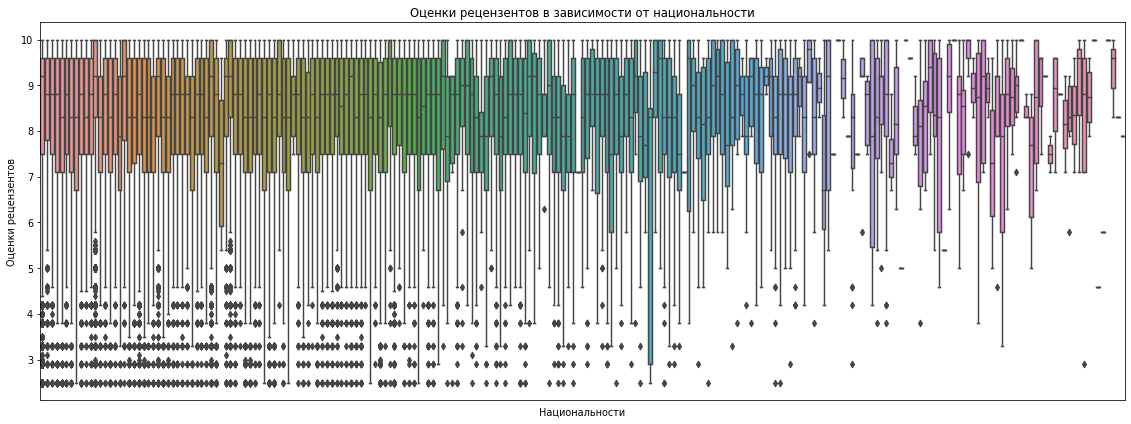

In [61]:
plt.figure(figsize=(20,7), dpi=70)
sns.boxplot(
    data=data.query('sample == 1'),
    x='code_3',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от национальности')
plt.xlabel('Национальности')
plt.xticks([])
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются. Попробуем сгруппировать признак и уменьшить число значений.

Используем тот же датасет **country_codes** и информацию о континентах и регионах.

## 8.1 Создадим признаки **continent** и **sub_region**

In [62]:
# объединяем датасеты
data = data.merge(
    country_codes[['code_3', 'continent', 'sub_region']],
    how='left',
    left_on='code_3',
    right_on='code_3',
    suffixes=(False, False)
)

Проверим, есть ли пустые значения

In [63]:
data[data['continent'].isna()][['reviewer_nationality', 'code_3']].value_counts()

reviewer_nationality                  code_3 
                                      Unknown    523
Abkhazia Georgia                      ABH        153
United States Minor Outlying Islands  UMI         74
Kosovo                                KOS         72
Crimea                                Crimea       6
Antarctica                            ATA          3
Cocos K I                             CCK          2
dtype: int64

Заполним значения вручную

In [64]:
continents = {
    'ABH':['Asia', 'Western Asia'],
    'UMI':['Oceania', 'Melanesia'],
    'KOS':['Europe', 'Southern Europe'],
    'Crimea':['Europe', 'Eastern Europe'],
    'ATA':['Oceania', 'Australia and New Zealand'],
    'CCK':['Oceania', 'Australia and New Zealand'],
    'Unknown':[data['continent'].mode()[0], data['sub_region'].mode()[0]]
}

Заполним пропуски признаков **continent** и **sub_region** значениями созданного словаря **continents**

In [65]:
data.loc[data['code_3'].isin(continents), 'continent'] = \
    data[data['code_3'].isin(continents)].apply(
        lambda x: continents[x['code_3']][0],
        axis=1
    )
data.loc[data['code_3'].isin(continents), 'sub_region'] = \
    data[data['code_3'].isin(continents)].apply(
        lambda x: continents[x['code_3']][1],
        axis=1
    )

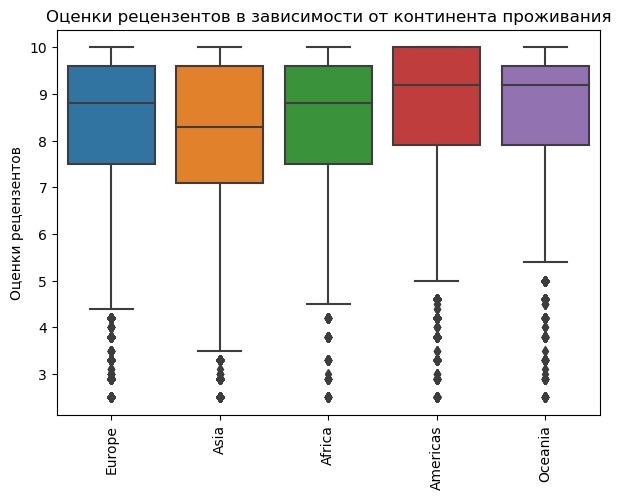

In [66]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='continent',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от континента проживания')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

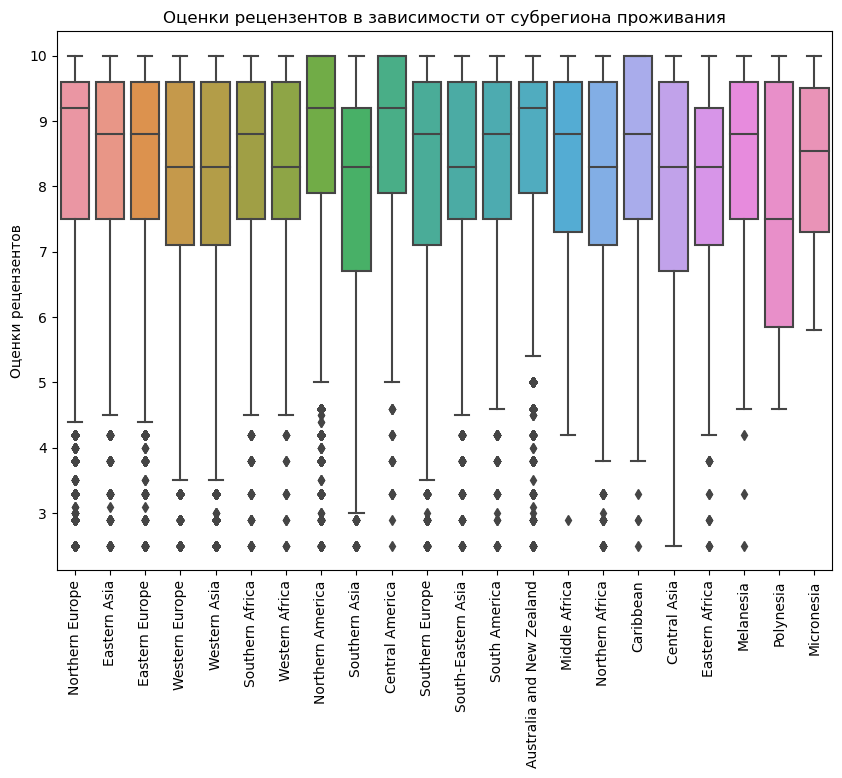

In [67]:
plt.figure(figsize=(10,7), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='sub_region',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от субрегиона проживания')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются еще значительней.

In [68]:
data['reviewer_nationality'] = data['code_3']

In [69]:
# добавим признаки country, code_3 и continent в список на удаление из финального датасета
drop_list.extend(['country', 'code_3', 'continent'])

## 8.2. Создадим признак **local_reviewer**
Признак будет содержать информацию о том, является ли рецензент жителем страны, в которой расположена гостиница

In [70]:
data['local_reviewer'] = data.apply(
    lambda x: 1
    if x['reviewer_nationality'] == x['hotel_country']
    else 0,
    axis=1
)

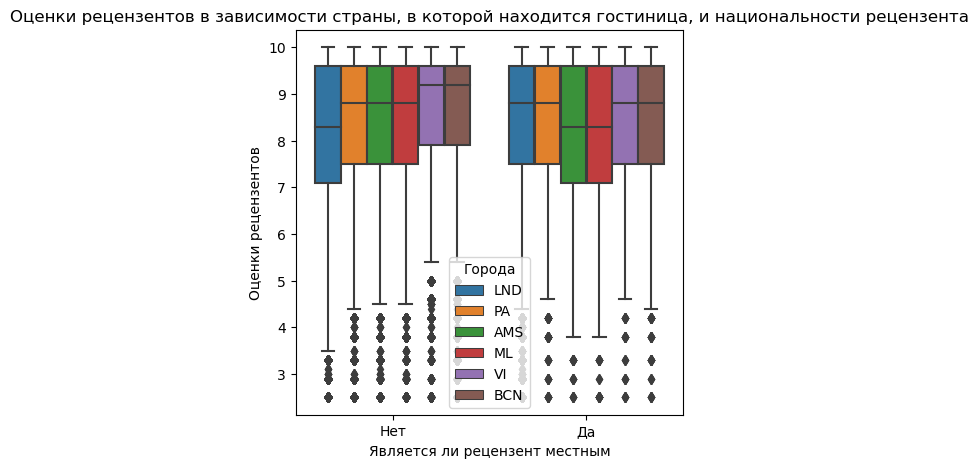

In [71]:
plt.figure(figsize=(5,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='local_reviewer',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости страны, в которой находится гостиница, и национальности рецензента')
plt.xlabel('Является ли рецензент местным')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower center',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [72]:
# мы получили всю возможную информацию из признака reviewer_nationality
# добавим его в список на удаление из финального датасета
drop_list.extend(['reviewer_nationality'])

# 9. Признаки **negative_review** и **review_total_negative_word_counts**

Рассмотрим 15 наиболее популярных негативных отзыва

In [73]:
data[
    ['negative_review', 'review_total_negative_word_counts']
].value_counts().sort_values(ascending=False)[:15]

negative_review  review_total_negative_word_counts
No Negative      0                                    127890
 Nothing         2                                     14295
 Nothing         3                                      4236
 nothing         2                                      2225
 N A             3                                      1037
 None            2                                       984
                 2                                       849
 N a             3                                       509
 Breakfast       2                                       407
 Small room      3                                       373
 Location        2                                       368
 Everything      2                                       326
 All good        3                                       318
 Nothing really  3                                       316
 none            2                                       302
dtype: int64

Видим, что в признаке содержится ключева фраза **No Negative**, означающая отсутствие негативного отзыва, так же видим большое количество синонимов **No Negative**. Отметим, что подсчет слов в **review_total_negative_word_counts** ведется не корректно (по всей видимости считается количество пробелов а не слов).

In [74]:
# уберем пробелы в начале и конце отзыва
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())
# пересчитаем количество слов в отзыве
data['review_total_negative_word_counts'] = data['negative_review'].apply(
    lambda x: 0 if x == 'No Negative' else  len(x.split(' '))
)

In [75]:
# подготовим данные для визуализации и дальнейшей обработки
negative_review_df = data.query('sample == 1').groupby(
    'negative_review',
    as_index=False
)['reviewer_score'].aggregate(['median', 'count']).sort_values(by='count',ascending=False)
negative_review_df = negative_review_df.reset_index()
negative_review_df.head(7)

negative_review  median  count
0     No Negative     9.6  95907
1         Nothing    10.0  13891
2         nothing    10.0   1879
3            None     9.6    871
4             N A    10.0    818
5                     9.6    606
6  Nothing really     9.6    435

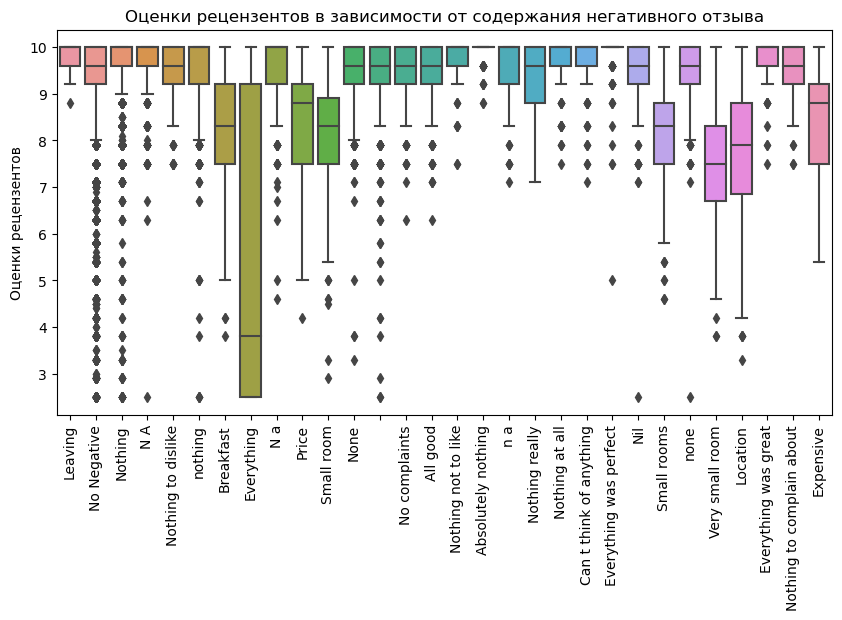

In [76]:
sample_mask = data['sample'] == 1
review_mask = data['negative_review'].isin(
    negative_review_df['negative_review'].values[:30] # ограничимся первыми 30 популярными отзывами
)

plt.figure(figsize=(10,5), dpi=100)
sns.boxplot(
    data=data[sample_mask & review_mask],
    x='negative_review',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от содержания негативного отзыва')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Оценки рецензентов')
plt.show()

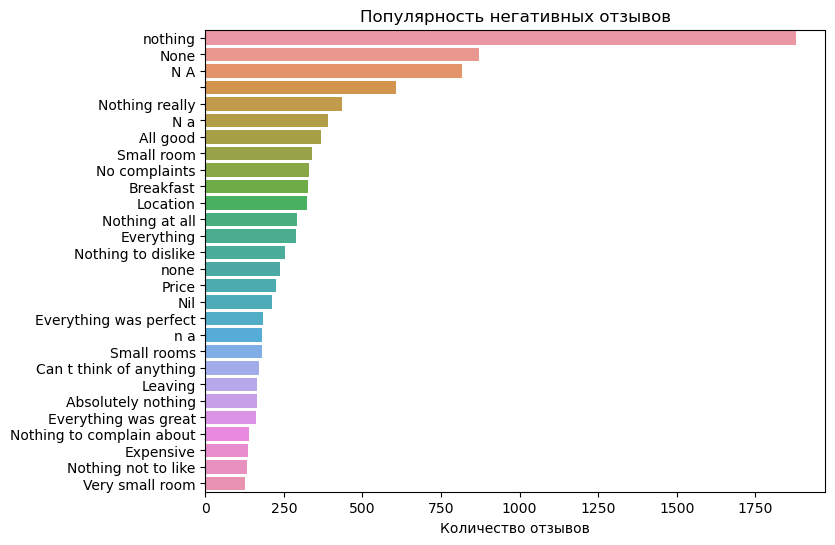

In [77]:
plt.figure(figsize=(8,6), dpi=100)
sns.barplot(
    # уберем первые два самых распространенных тэга No Negative и Nothing
    data=negative_review_df[2:30],
    x='count',
    y='negative_review'
)
plt.title('Популярность негативных отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('')
plt.show()

Большое количество отзывов носят положительную коннатацию

In [78]:
# создадим множество из всех негативных отзывов
negative_review_set = set()
data['negative_review'].apply(lambda x: negative_review_set.add(x))
len(negative_review_set)

326566

In [79]:
# отфильтруем negative_review_set, оставив те отзывы, медианная оценка которых > 9
positive_in_negative = list()

review_mask = negative_review_df['negative_review'].isin(negative_review_set)
negative_review_df[review_mask].apply(
    lambda x: positive_in_negative.append(x['negative_review'])
    if x['median'] > 9
    else None,
    axis=1
)
len(positive_in_negative)

81393

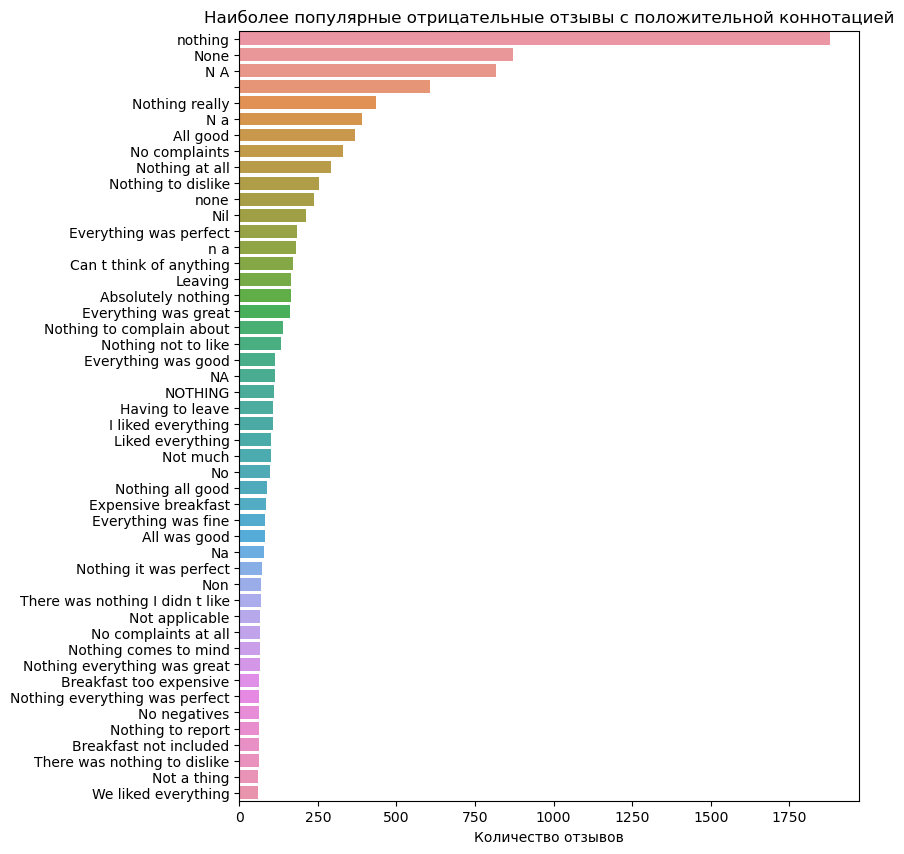

In [80]:
review_mask = negative_review_df[
    'negative_review'
].isin(positive_in_negative)

plt.figure(figsize=(8,10), dpi=100)
sns.barplot(
    data=negative_review_df[review_mask][2:50],
    x='count',
    y='negative_review'
)
plt.title('Наиболее популярные отрицательные отзывы с положительной коннотацией')
plt.xlabel('Количество отзывов')
plt.ylabel('')
plt.show()

Видим, что слова **Nothing, Excellent, None, NA** часто встречаются в отзывах положительной коннотации

In [81]:
# создадим словарь для поиска слов в отзывах
hiden_words = {
    'Nothing':'(^[N,n]\w{,3}[T,t]{1}\w{,3}[G,g])|(\s[N,n]\w{,3}[T,t]{1}\w{,3}[G,g])',
    'Excellent':'(^[E,e][X,x]\w{,3}[L,l]{1,2}\w{,3}[T,t])|(\s[E,e][X,x]\w{,3}[L,l]{1,2}\w{,3}[T,t])',
    'None':'(^[N,n]\w{,1}[N,n]\w{,1}$)|(\s[N,n]\w{,1}[N,n]\w{,1}$)|(^[N,n]\s{,1}[A,a,O,o]$)|(\s[N,n]\s{,1}[A,a,O,o]$)',
    'Leaving':'(^[L,l]\w{,2}[V,v]\w{,2}[G,g]{1})|(\s[L,l]\w{,2}[V,v]\w{,2}[G,g]{1}$)'
}
# найдем отзывы положительной коннотации по ключевым словам
reviews_finder = []
for review in negative_review_set: # поиск по всему множеству отзывов
        if len(review.split(' ')) < 6:
            for word in hiden_words:
                if re.search(hiden_words[word], review):
                    reviews_finder.append(review)
len(reviews_finder)

2284

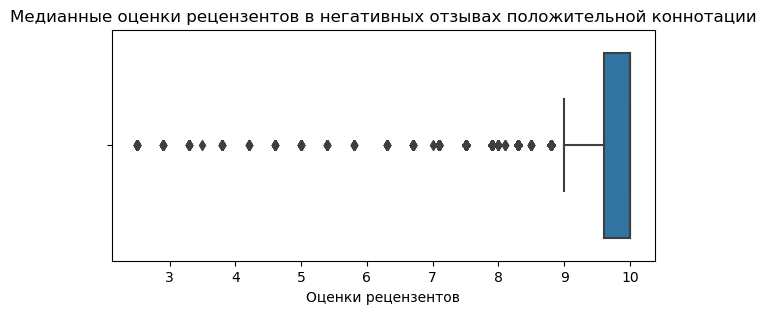

In [82]:
sample_mask = data['sample'] == 1
review_mask = data['negative_review'].isin(reviews_finder)

plt.figure(figsize=(7,3), dpi= 100)
sns.boxplot(
    data=data[sample_mask & review_mask],
    x = 'reviewer_score'
)
plt.title('Медианные оценки рецензентов в негативных отзывах положительной коннотации')
plt.xlabel('Оценки рецензентов')
plt.ylabel('')
plt.show()

Заменим ключевое слово **No Negative** на нейтральное **EDA** и объединим их с пустыми отзывами

In [83]:
data['negative_review'] = data['negative_review'].apply(
    lambda x: 'EDA'
    if x in ['No Negative', '']
    else x
)

Появилась идея того, что подсчет символов может давать лучший результат, так как будет учитывать эмоциональность например большое количество ! знаков усиливает контекст.

В ходе тестов идея подтвердилась и признак содержащий количество символов дал (не значительно) лучший результат. 

In [84]:
# пересчитаем количество символов в отзыве
data['review_total_negative_word_counts'] = data['negative_review'].apply(
    lambda x: 0 if x == 'EDA' else  len(x)
)

Заменим отзывы из списка **reviews_finder** на значение **Positive**

In [85]:
data['negative_review'] = data['negative_review'].apply(
    lambda x: 'Positive' # если отзыв находится в reviews_finder, возвращаем 'Positive'
    if x in reviews_finder
    else x # иначе возвращаем отзыв без изменений
)

## 9.1. Создадим признак **empty_negative_review**
Признак будет отмечать те отзывы, которые рецензент решил не заполнять

In [86]:
data['empty_negative_review'] = data['negative_review'].apply(lambda x: 1 if x=='EDA' else 0)

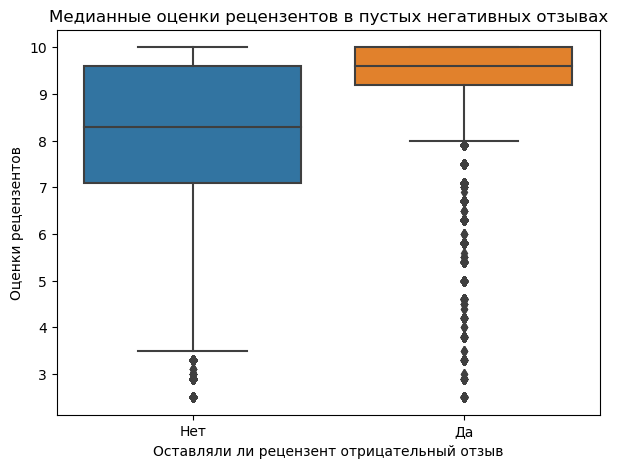

In [87]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x = 'empty_negative_review',
    y = 'reviewer_score'
)
plt.title('Медианные оценки рецензентов в пустых негативных отзывах')
plt.xlabel('Оставляли ли рецензент отрицательный отзыв')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

## 9.2. Создадим признак **words_difference_in_negative_review**
Признак будет содержать информацию о разнице между негативными и позитивными словами в отзыве

- Используем список позитивных слов: [List of POSITIVE opinion words (or sentiment words)](https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt)
- Используем список негативных слов: [List of NEGATIVE opinion words (or sentiment words)](https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/negative-words.txt)

In [88]:
# подгружаем список позитивных слов
positive_words = pd.read_csv('/kaggle/input/sentiment-words/positive-words.csv')
positive_words_list = positive_words['words'].value_counts().index

# подгружаем список негативных слов
negative_words = pd.read_csv('/kaggle/input/sentiment-words/negative-words.csv')
negative_words_list = negative_words['words'].value_counts().index

Создадим функцию подсчета разницы сентиментальных слов

In [89]:
def words_difference(
    review:str,
    review_type:str,
    positive_list = positive_words_list,
    negative_list = negative_words_list
):
    '''
    Функция подсчитывает разницу между количеством слов различной коннотации в отзыве
    
    review - отзыв
    review_type - тип отзыва (positive / negative)
    
    positive_list - список позитивных слов
    negative_list - список негативных слов
    
    count - количество сентиментальных слов в строке
    '''
    
    positive_words = 0
    negative_words = 0
    for word in review.lower().split(' '):
        if word in positive_list:
            positive_words += 1
        elif word in negative_list:
            negative_words += 1
    
    if review_type is 'positive':
        return positive_words - negative_words
    elif review_type is 'negative':
        return negative_words - positive_words

In [90]:
# посчитаем разницу слов в отзыве
data['words_difference_in_negative_review'] = data['negative_review'].apply(
    words_difference,
    review_type = 'negative'
)

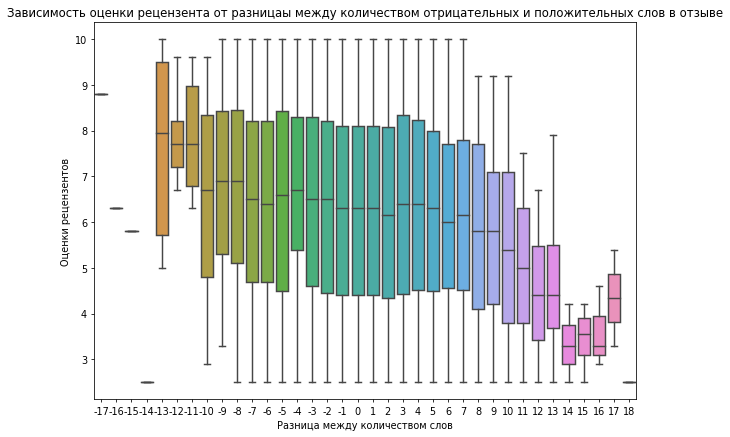

In [91]:
plt.figure(figsize=(10,7), dpi= 70)
sns.boxplot(
    data=data.query('sample == 1').groupby(
        ['words_difference_in_negative_review', 'reviewer_score'],
        as_index=False)['sample'].count(),
    x='words_difference_in_negative_review',
    y='reviewer_score'
)
plt.title('Зависимость оценки рецензента от разницаы между количеством отрицательных и положительных слов в отзыве')
plt.xlabel('Разница между количеством слов')
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

## 9.3. Создадим признаки **negative_review_neg**, **negative_review_neu**, **negative_review_pos** и **negative_review_compound**
Используем **SentimentIntensityAnalyzer** библиотеки **nltk** для анализа отзыва 

In [92]:
%%time

sentiment_analyzer = SentimentIntensityAnalyzer()

data['negative_sentiment_analyzer'] = data['negative_review'].apply(
    lambda x: sentiment_analyzer.polarity_scores(x)
)

# создаем признаки:
data['negative_review_neg'] = data['negative_sentiment_analyzer'].apply(
    lambda x: x['neg']
)
data['negative_review_neu'] = data['negative_sentiment_analyzer'].apply(
    lambda x: x['neu']
)
data['negative_review_pos'] = data['negative_sentiment_analyzer'].apply(
    lambda x: x['pos']
)
data['negative_review_compound'] = data['negative_sentiment_analyzer'].apply(
    lambda x: x['compound']
)

# добавим negative_sentiment_analyzer в список на удаление из финального датасета
drop_list.extend(['negative_sentiment_analyzer'])

CPU times: user 2min 12s, sys: 331 ms, total: 2min 13s
Wall time: 2min 13s


In [93]:
# мы получили всю возможную информацию из признака negative_review
# добавим его в список на удаление из финального датасета
drop_list.extend(['negative_review'])

# 10. Признаки **positive_review** и **review_total_positive_word_counts**
Рассмотрим 15 наиболее популярных позитивных отзыва

In [94]:
data[['positive_review', 'review_total_positive_word_counts']].value_counts()[:15]

positive_review      review_total_positive_word_counts
No Positive          0                                    35946
 Location            2                                     9222
 Everything          2                                     2284
 location            2                                     1677
 Nothing             2                                     1243
 The location        3                                     1126
 Great location      3                                     1047
 Good location       3                                      927
 Location            3                                      915
 Everything          3                                      613
 Breakfast           2                                      608
 Friendly staff      3                                      515
 Staff               2                                      453
 Excellent location  3                                      392
 Great location      4                           

Ситуация аналогична признаку **review_total_negative_word_counts**

Уберем пробелы в начале и конце строк и посмотрим на позитивные отзывы с низкой оценкой.

In [95]:
# уберем пробелы в начале и конце отзыва
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())
# пересчитаем количество слов в отзыве
data['review_total_positive_word_counts'] = data['positive_review'].apply(
    lambda x: 0 if x == 'No Positive' else  len(x.split(' '))
)

In [96]:
# подготовим данные для визуализации и дальнейшей обработки
positive_review_df = data.query('sample == 1').groupby(
    'positive_review',
    as_index=False
)['reviewer_score'].aggregate(['median', 'count']).sort_values(by='count',ascending=False)
positive_review_df = positive_review_df.reset_index()
positive_review_df.head(10)

positive_review  median  count
0     No Positive     7.1  26885
1        Location     7.1   7496
2      Everything    10.0   2146
3        location     7.1   1296
4         Nothing     3.3   1101
5  Great location     7.9   1089
6    The location     6.7    982
7   Good location     6.7    904
8       Breakfast     7.1    493
9  Friendly staff     7.9    453

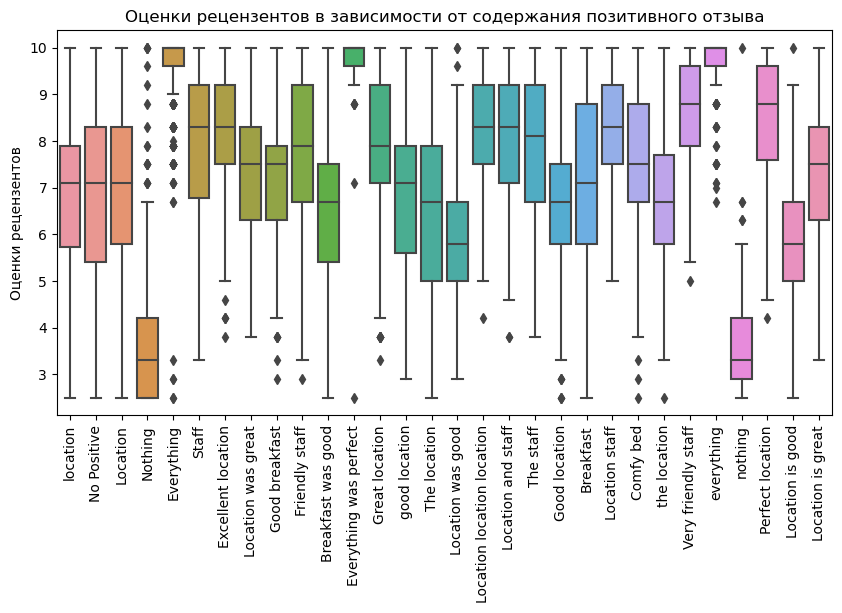

In [97]:
sample_mask = data['sample'] == 1
review_mask = data['positive_review'].isin(
    positive_review_df['positive_review'].values[:30] # ограничимся первыми 30 популярными отзывами
)

plt.figure(figsize=(10,5), dpi=100)
sns.boxplot(
    data=data[sample_mask & review_mask],
    x='positive_review',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от содержания позитивного отзыва')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Оценки рецензентов')
plt.show()

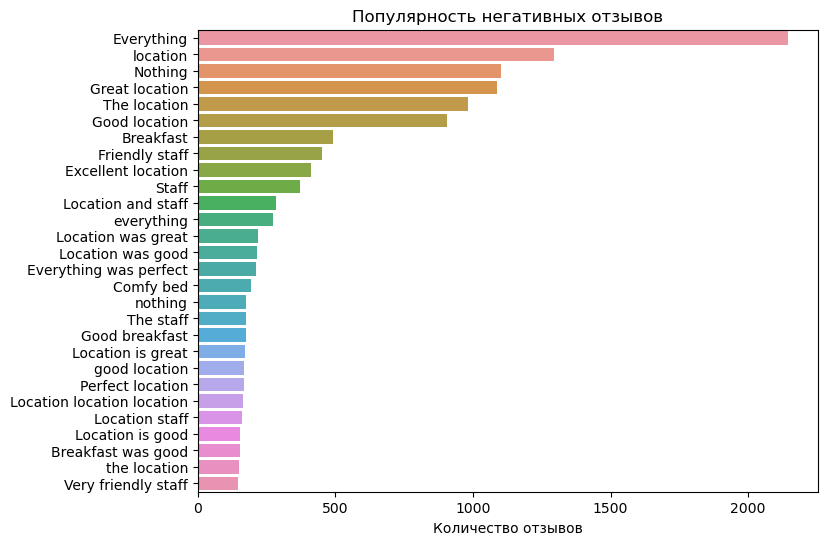

In [98]:
plt.figure(figsize=(8,6), dpi=100)
sns.barplot(
    # уберем первые два самых распространенных тэга No Positive и Location
    data=positive_review_df[2:30],
    x='count',
    y='positive_review'
)
plt.title('Популярность негативных отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('')
plt.show()

In [99]:
# создадим множество из всех положительных отзывов
positive_review_set = set()
data['positive_review'].apply(lambda x: positive_review_set.add(x))
len(positive_review_set)

407552

Заменим отзывы из списка not_positive_review на значение **Negative**

In [100]:
# отфильтруем positive_review_set, оставив те отзывы, медианная оценка которых < 4.5
negative_in_positive = list()

review_mask = positive_review_df['positive_review'].isin(positive_review_set)
positive_review_df[review_mask].apply(
    lambda x: negative_in_positive.append(x['positive_review'])
    if x['median'] < 4.5
    else None,
    axis=1
)
len(negative_in_positive)

4912

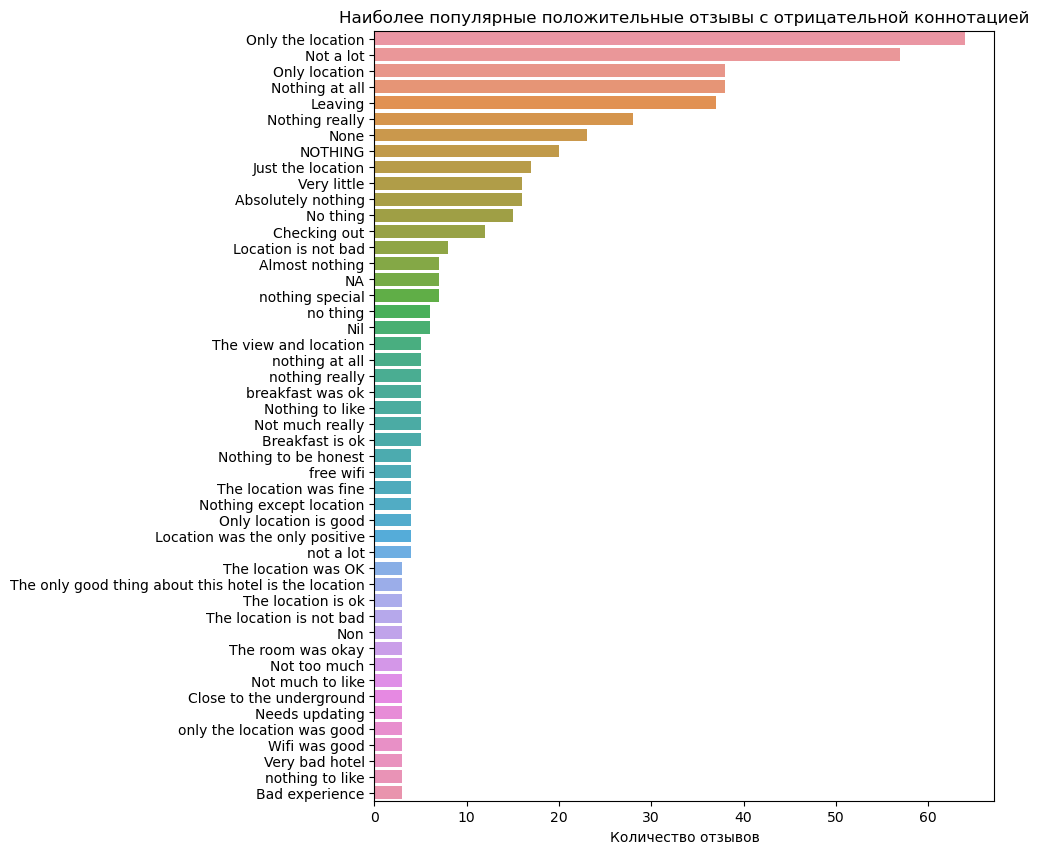

In [101]:
review_mask = positive_review_df[
    'positive_review'
].isin(negative_in_positive)

plt.figure(figsize=(8,10), dpi=100)
sns.barplot(
    data=positive_review_df[review_mask][2:50],
    x='count',
    y='positive_review'
)
plt.title('Наиболее популярные положительные отзывы с отрицательной коннотацией')
plt.xlabel('Количество отзывов')
plt.ylabel('')
plt.show()

In [102]:
# создадим словарь для поиска слов в отзывах
hiden_words = {
    'Nothing':'(^[N,n]\w{,3}[T,t]{1}\w{,3}[G,g])|(\s[N,n]\w{,3}[T,t]{1}\w{,3}[G,g])',
    'None':'(^[N,n]\w{,1}[N,n]\w{,1}$)|(\s[N,n]\w{,1}[N,n]\w{,1}$)|(^[N,n]\s{,1}[A,a,O,o]$)|(\s[N,n]\s{,1}[A,a,O,o]$)',
    'Leaving':'(^[L,l]\w{,2}[V,v]\w{,2}[G,g]{1})|(\w[L,l]\w{,2}[V,v]\w{,2}[G,g]{1}$)',
    'Location':'[O,o][N,n][L,l][Y,y].{,5}[L,l][O,o][C,c]'
}
# найдем отзывы положительной коннотации по ключевым словам
reviews_finder = []
for review in positive_review_set: # поиск по всему множеству отзывов
        if len(review.split(' ')) < 6:
            for word in hiden_words:
                if re.search(hiden_words[word], review):
                    reviews_finder.append(review)
len(reviews_finder)

501

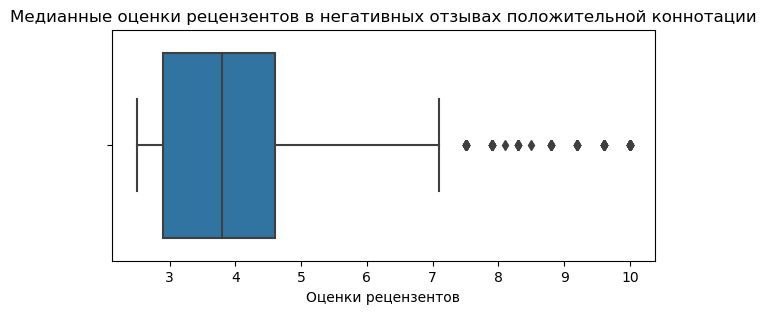

In [103]:
sample_mask = data['sample'] == 1
review_mask = data['positive_review'].isin(reviews_finder)

plt.figure(figsize=(7,3), dpi= 100)
sns.boxplot(
    data=data[sample_mask & review_mask],
    x = 'reviewer_score'
)
plt.title('Медианные оценки рецензентов в негативных отзывах положительной коннотации')
plt.xlabel('Оценки рецензентов')
plt.ylabel('')
plt.show()

Заменим ключевое слово **No Positive** на нейтральное **EDA** и объединим их с пустыми отзывами

In [104]:
data['positive_review'] = data['positive_review'].apply(
    lambda x: 'EDA'
    if x in ['No Positive', '']
    else x
)

In [105]:
# пересчитаем количество слов в отзыве
#data['review_total_positive_word_counts'] = data['positive_review'].apply(
#    lambda x: 0 if x == 'EDA' else  len(x.split(' '))
#)
data['review_total_positive_word_counts'] = data['positive_review'].apply(
    lambda x: 0 if x == 'EDA' else  len(x)
)

Заменим отзывы из списка **reviews_finder** на значение **Negative**

In [106]:
data['positive_review'] = data['positive_review'].apply(
    lambda x: 'Negative' # если отзыв находится в reviews_finder, возвращаем Negative
    if x in reviews_finder
    else x # иначе возвращаем отзыв без изменений
)

## 10.1. Создадим признак **empty_positive_review**
Признак будет отмечать те отзывы, которые рецензент решил не заполнять

In [107]:
data['empty_positive_review'] = data['positive_review'].apply(lambda x: 1 if x=='EDA' else 0)

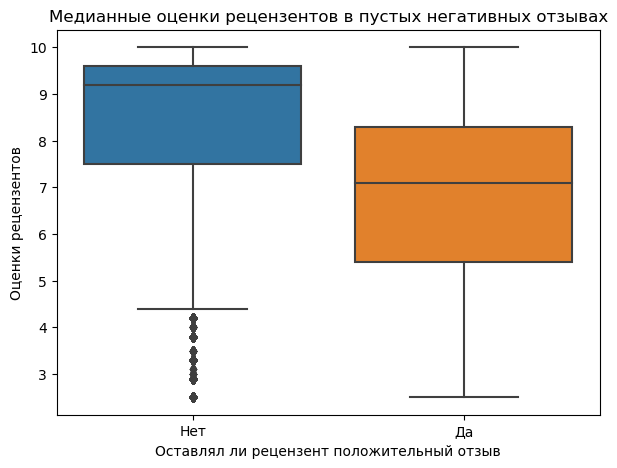

In [108]:
plt.figure(figsize=(7,5), dpi= 100)
sns.boxplot(
    data=data.query('sample == 1'),
    x = 'empty_positive_review',
    y = 'reviewer_score'
)
plt.title('Медианные оценки рецензентов в пустых негативных отзывах')
plt.xlabel('Оставлял ли рецензент положительный отзыв')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.ylabel('Оценки рецензентов')
plt.show()

## 10.2. Создадим признак **words_difference_in_positive_review**
Признак будет содержать информацию о разнице между позитивными и негативными словами в отзыве

In [109]:
# посчитаем разницу слов в отзыве
data['words_difference_in_positive_review'] = data['positive_review'].apply(
    words_difference,
    review_type = 'positive'
)

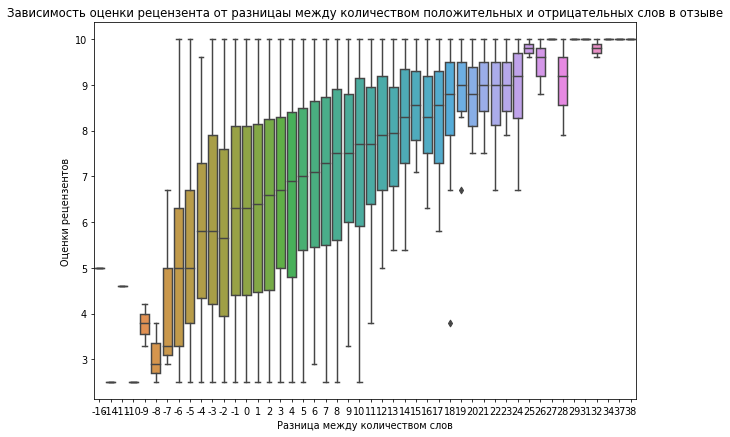

In [110]:
plt.figure(figsize=(10,7), dpi= 70)
sns.boxplot(
    data=data.query('sample == 1').groupby(
        ['words_difference_in_positive_review', 'reviewer_score'],
        as_index=False)['sample'].count(),
    x='words_difference_in_positive_review',
    y='reviewer_score'
)
plt.title('Зависимость оценки рецензента от разницаы между количеством положительных и отрицательных слов в отзыве')
plt.xlabel('Разница между количеством слов')
plt.ylabel('Оценки рецензентов')
plt.show()

## 10.3. Создадим признаки **positive_review_neg**, **positive_review_neu**, **positive_review_pos** и **positive_review_compound**
Используем **SentimentIntensityAnalyzer** библиотеки **nltk** для анализа отзыва 

In [111]:
%%time

data['positive_sentiment_analyzer'] = data['positive_review'].apply(
    lambda x: sentiment_analyzer.polarity_scores(x)
)

# создаем признаки:
data['positive_review_neg'] = data['positive_sentiment_analyzer'].apply(
    lambda x: x['neg']
)
data['positive_review_neu'] = data['positive_sentiment_analyzer'].apply(
    lambda x: x['neu']
)
data['positive_review_pos'] = data['positive_sentiment_analyzer'].apply(
    lambda x: x['pos']
)
data['positive_review_compound'] = data['positive_sentiment_analyzer'].apply(
    lambda x: x['compound']
)

# добавим positive_sentiment_analyzer в список на удаление из финального датасета
drop_list.extend(['positive_sentiment_analyzer'])

CPU times: user 2min 20s, sys: 321 ms, total: 2min 20s
Wall time: 2min 20s


In [112]:
# мы получили всю возможную информацию из признака positive_review
# добавим его в список на удаление из финального датасета
drop_list.extend(['positive_review'])

# 11. Признак **tags**

In [113]:
data['tags'].head(3)

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
Name: tags, dtype: object

Признак содержит информацию в виде списка (но в формате строки).

Преобразуем данные в кортеж, используя разделение строки по символу **'**


In [114]:
# символы, которые необходимо удалить
exception_set = {'[', ', ', ']'}

data['tags'] = data['tags'].apply(
    lambda x: set(x.split("'")).difference(exception_set)
)

Создадим датафрейм, содержащий все известные тэги

In [115]:
tags_df = data[['tags', 'sample']].explode('tags')
tags_df = tags_df.groupby('tags', as_index=False).count()
tags_df.head(3)

tags  sample
0                1 King Bed Guest Room       27
1   2 Adjacent Non Communicating Rooms       26
2                     2 Adjacent Rooms       22

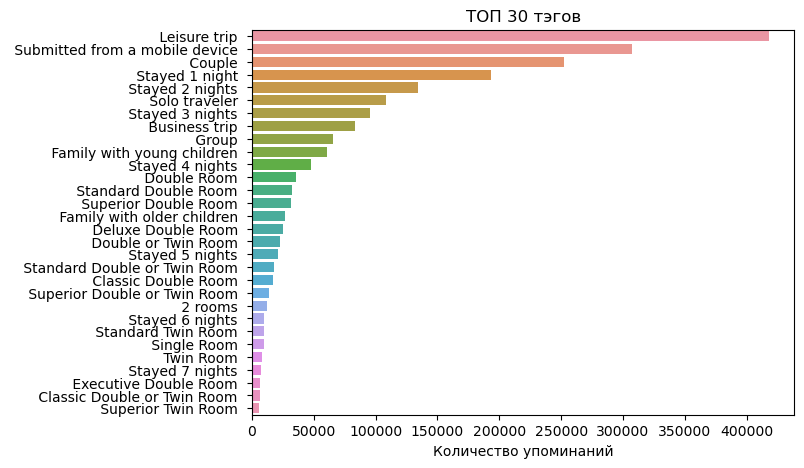

In [116]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df.sort_values(by='sample', ascending=False)[:30],
    x='sample',
    y='tags'
)
plt.title('ТОП 30 тэгов')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

Можно выделить несколько типов тэгов:

1. Цел поездки (отдых, работа и т.д.)
2. Использовался ли мобильный телефон при бронировании (да / нет)
3. Тип поездки (один, пара, группа, семья)
4. Количество ночей (1, 2, и т.д.)
5. Тип номера (Standard, Deluxe и т.д.)

In [117]:
# создадим множество тэгов
tags_set = set(tags_df['tags'].values)
len(tags_set)

2428

## 11.1 Создадим признак **trip_purpose**
Признак будет содержать информацию о цели бронирования.
- **Business** - деловая поездка (Business)
- **Leisure** - отдых (Leisure)
- **Unknown** - цель поездки не известна

In [118]:
# поиск возможных тэгов с указанием цели поездки
purpose_set = set()
for tag in tags_set:
    if 'trip' in tag:
        purpose_set.add(tag)
purpose_set

{' Business trip ', ' Leisure trip '}

In [119]:
# создадим словарь для наполнения 
trip_purpose = {
    ' Business trip ':'Business',
    ' Leisure trip ':'Leisure'
}

In [120]:
data['trip_purpose'] = data['tags'].apply(
    lambda x: trip_purpose[x.intersection(purpose_set).pop()]
    if x.intersection(purpose_set)
    else 'Unknown'
)

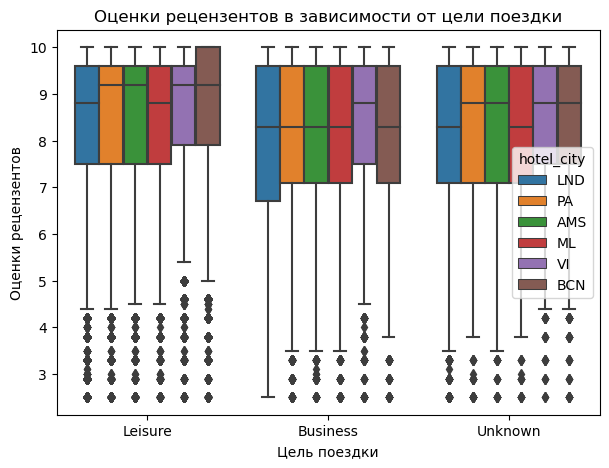

In [121]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='trip_purpose',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от цели поездки')
plt.xlabel('Цель поездки')
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [122]:
# удалим из множества обработанные тэги
tags_set = tags_set.difference(purpose_set)
len(tags_set)

2426

## 11.2. Создадим признак **mobile_device**
Признак будет содержать информацию о том, использовалось ли мобильное устройство при бронировании.
- **1** - использовалось
- **0** - не использовалось или нет информации

In [123]:
# поиск возможных тэгов с указанием мобильных устройств
device_set = set()
for tag in tags_set:
    if 'mobile device' in tag:
        device_set.add(tag)
#device_set

In [124]:
data['mobile_device'] = data['tags'].apply(
    lambda x: 1
    if x.intersection(device_set)
    else 0
)

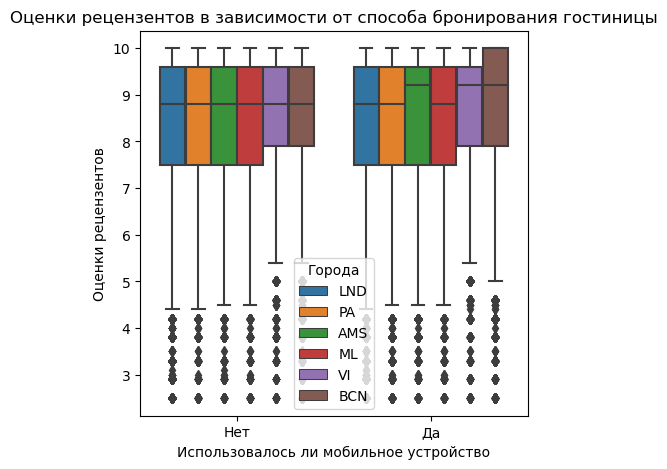

In [125]:
plt.figure(figsize=(5,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='mobile_device',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от способа бронирования гостиницы')
plt.xlabel('Использовалось ли мобильное устройство')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower center',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [126]:
# удалим из множества обработанный тэг
tags_set = tags_set.difference(device_set)
len(tags_set)

2425

## 11.3. Создадим признак **trip_type**
Признак будет содержать информацию о типе поездки:
- **Solo** - одиночное путешествие
- **Couple** - путешествие в паре
- **Group** - групповое путешествие
- **Family** - семейное путешествие
- **Unknowon** - тип поездки не известен

In [127]:
# поиск возможных тэгов с указанием типа поездки
trip_type_set = set()
for tag in tags_set:
    for trip_type in ['solo', 'couple', 'group', 'family with']:
        if trip_type in tag.lower() and 'room' not in tag.lower():
            trip_type_set.add(tag)
#trip_type_set

In [128]:
# создадим словарь для наполнения 
trip_type = {
    ' Solo traveler ':'Solo',
    ' Couple ':'Couple',
    ' Group ':'Group',
    ' Family with young children ':'Family',
    ' Family with older children ':'Family'
}

In [129]:
data['trip_type'] = data['tags'].apply(
    lambda x: trip_type[x.intersection(trip_type).pop()]
    if x.intersection(trip_type)
    else 'Unknowon'
)

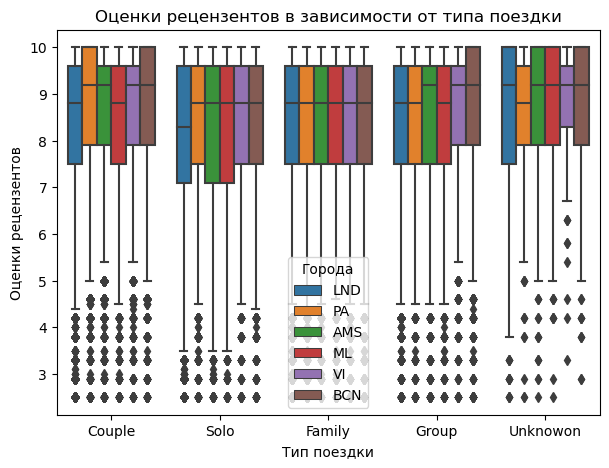

In [130]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='trip_type',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от типа поездки')
plt.xlabel('Тип поездки')
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower center',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [131]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(trip_type_set)
len(tags_set)

2420

## 11.4. Создадим признак **number_of_nights**
Признак будет содержать информацию о количестве проведенных ночей
- **1-31** - количество ночей
- **0** - нет информации

In [132]:
# поиск возможных тэгов с указанием количества ночей
nights_set = set()
for tag in tags_set:
    if 'stayed' in tag.lower():
        nights_set.add(tag)
#nights_set

In [133]:
number_of_nights = {}
for nights in nights_set:
    number_of_nights.update(
        {nights:int(re.findall('\d{1,2}', nights)[0])}
    )
#number_of_nights

In [134]:
data['number_of_nights'] = data['tags'].apply(
    lambda x: number_of_nights[x.intersection(number_of_nights).pop()]
    if x.intersection(number_of_nights)
    else 0
)
data['number_of_nights'] = data['number_of_nights'].astype(int)

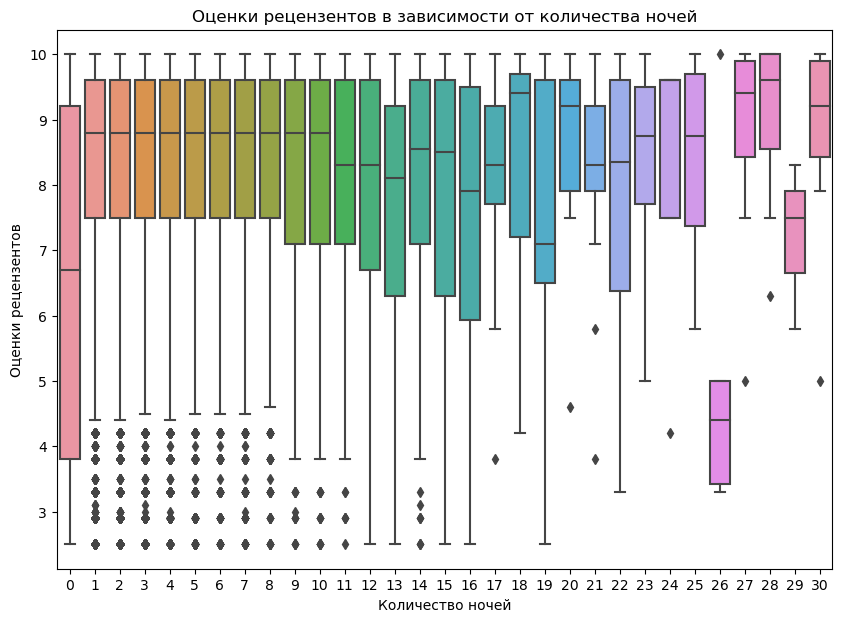

In [135]:
plt.figure(figsize=(10,7), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='number_of_nights',
    y='reviewer_score'
)
plt.title('Оценки рецензентов в зависимости от количества ночей')
plt.xlabel('Количество ночей')
plt.ylabel('Оценки рецензентов')
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [136]:
data['number_of_nights'].value_counts(normalize=True)[:10]

1     0.375472
2     0.259700
3     0.185794
4     0.092716
5     0.040418
6     0.018955
7     0.014346
8     0.004851
9     0.002507
10    0.001724
Name: number_of_nights, dtype: float64

Имеет смысл объединить все значения признака,превышающие 7 ночей

In [137]:
# Объединим количество ночей более 7
data['number_of_nights'] = data['number_of_nights'].apply(
    lambda x: 8
    if x > 7
    else x
)

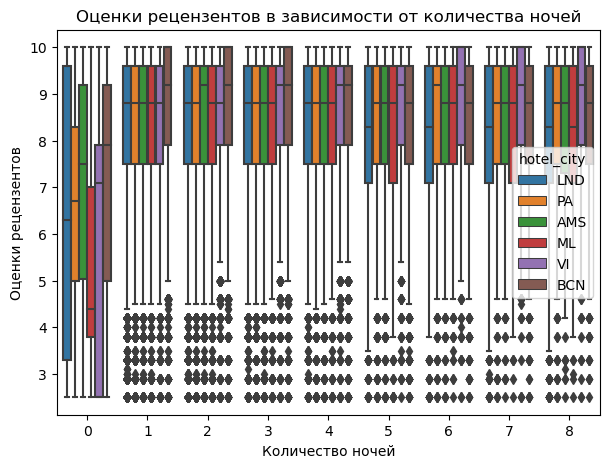

In [138]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='number_of_nights',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от количества ночей')
plt.xlabel('Количество ночей')
plt.ylabel('Оценки рецензентов')
plt.show()

In [139]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(nights_set)
len(tags_set)

2389

## 11.5. Создадим признак **accommodation_type**
Признак будет содержать информацию о типе размещения в номере
- **SGL** (Single) – одноместное
- **DBL** (Double ot Twin) – двухместное
- **TRPL** (Triple) – трехместное
- **QDPL** (Quadriple) – четырехместное
- **Unknown** - тип размещения неизвестен

In [140]:
def tags_filter (filtered_words:set, key_words:set, tags:set, additional_words=None):
    '''
    Функция поиска тэгов по ключевым словам
    
    filtered_words - множество, состоящее из слов по которым идет поиск тэга
                    (исключаются из key_words) 
    
    key_words - множество, состоящее из ключевых слов, относящихся к определенной
                категории тэгов
    
    tags - множество тэгов
    
    additional_words - список дополнительных слов, позволяющих сделать поиск более точным,
                       по умолчанию None
    
    new_set - возвращает множество отфильтрованных тэгов
    '''
    new_set = set()
    for tag in tags:
        temp = set(tag.lower().split(' '))
        if additional_words is None:
            if temp.intersection(filtered_words) and \
               not temp.intersection(key_words.difference(filtered_words)):
                new_set.add(tag)
        else:
            for word in additional_words:
                if (temp.intersection(filtered_words) or word.lower() in tag.lower()) and \
                   not temp.intersection(key_words.difference(filtered_words)):
                    new_set.add(tag)
    return new_set

In [141]:
# создадим копию tags_set
# она понадобится в текущем состоянии
# для создания признака room_type 
tags_set_copy = tags_set.copy()

In [142]:
# зададим ключевые слова для нахождения тэгов, относящихся к типу размещения в номере
key_words = {'single', 'double', 'twin', 'triple', 'quadriple', 'quad', 'quadruple'}

Найдем тэги, подходящие под четырехместное размещение **QDPL**

In [143]:
filtered_words = {'quadriple', 'quad', 'quadruple'}
# слова, встречающиеся в тэгах, и относящиеся к QDPL
additional_words = [
    '4 adults', '4 persons',
    '4 people', '4 guest',
    '2 adults 2 children',
    '2 adults and 2 children',
    '3 adults 1 child'
]
qdpl = tags_filter(filtered_words, key_words, tags_set, additional_words)
#qdpl

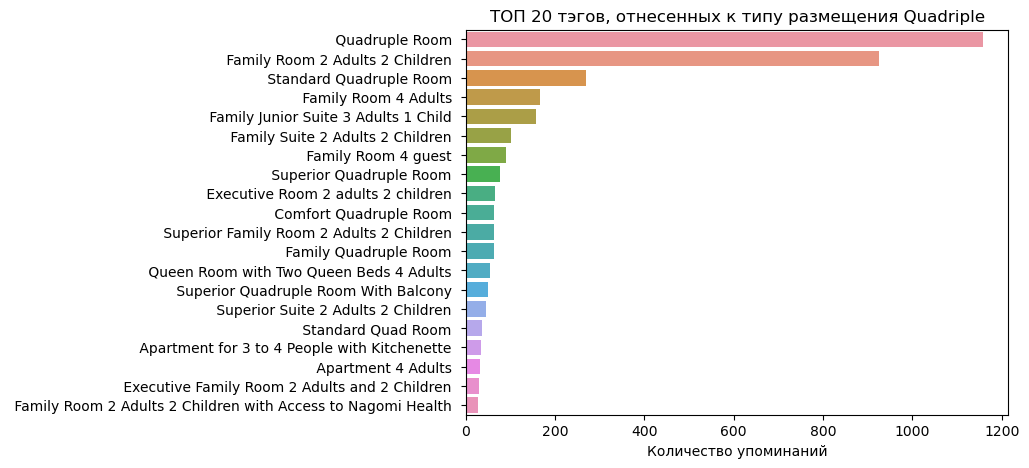

In [144]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(qdpl)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к типу размещения Quadriple')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [145]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(qdpl)
len(tags_set)

2324

Найдем тэги, подходящие под трехместное размещение **TRPL**

In [146]:
filtered_words = {'triple'}
# слова, встречающиеся в тэгах, и относящиеся к TRPL
additional_words = [
    '3 adults', '3 persons',
    '3 people', '3 guest',
    '2 adults 1 child',
    '2 adults and 1 child'
]
trpl = tags_filter(filtered_words, key_words, tags_set, additional_words)
#trpl

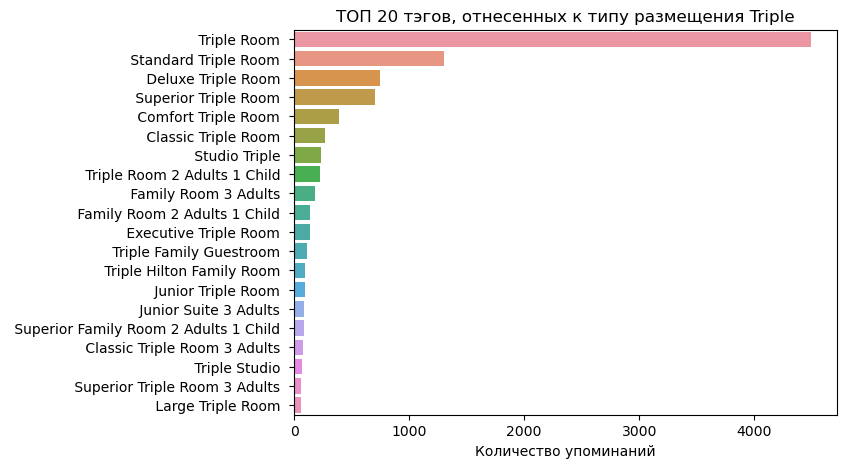

In [147]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(trpl)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к типу размещения Triple')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [148]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(trpl)
len(tags_set)

2209

Найдем тэги, подходящие под двухместное размещение **DBL**

In [149]:
filtered_words = {'double', 'twin'}
# слова, встречающиеся в тэгах, и относящиеся к DBL
additional_words = [
    '2 adults', '2 persons',
    '2 guest', '2 people',
    'king', 'queen'
]
dbl = tags_filter(filtered_words, key_words, tags_set, additional_words)
#dbl

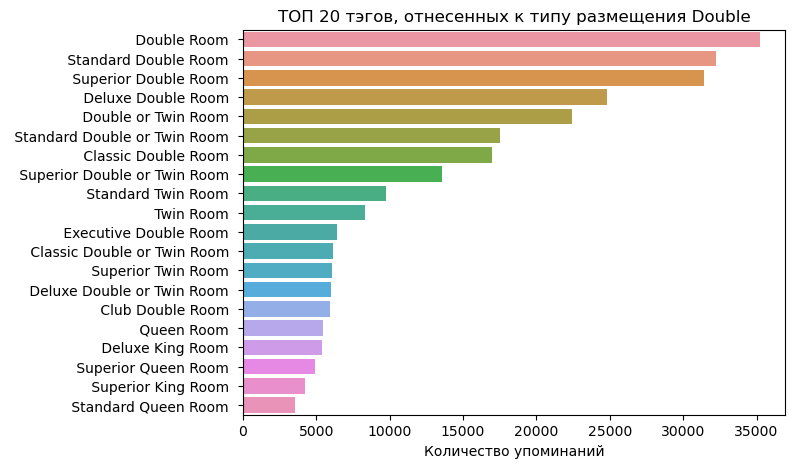

In [150]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(dbl)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к типу размещения Double')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [151]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(dbl)
len(tags_set)

855

Найдем тэги, подходящие под одноместное размещение **SGL**

In [152]:
filtered_words = {'single'}
# слова, встречающиеся в тэгах, и относящиеся к SGL
additional_words = ['1 adult']
sgl = tags_filter(filtered_words, key_words, tags_set, additional_words)
#sgl

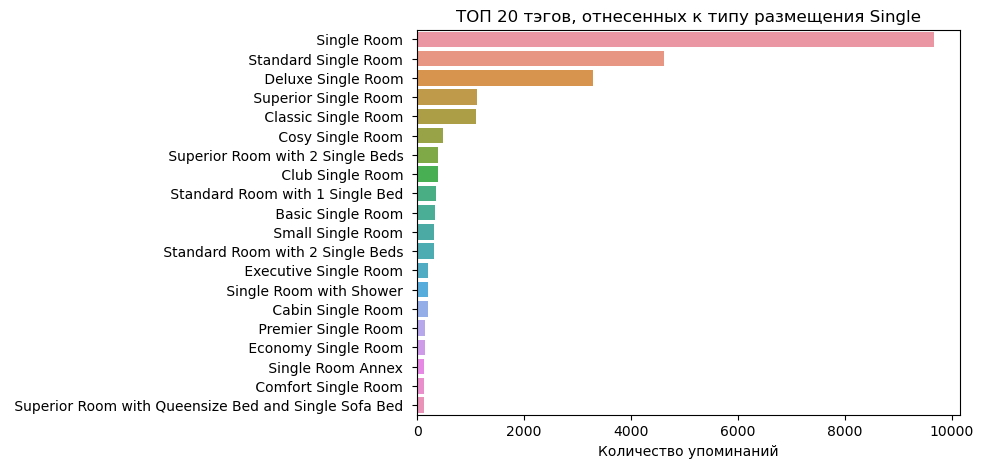

In [153]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(sgl)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к типу размещения Single')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [154]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(sgl)
len(tags_set)

775

In [155]:
data['accommodation_type'] = data['tags'].apply(
    lambda x: 'SGL'
    if x.intersection(sgl)
    else ('DBL'
          if x.intersection(dbl)
          else ('TRPL'
                if x.intersection(trpl)
                else ('QDPL'
                      if x.intersection(qdpl)
                      else 'Unknowon'
                     )
               )
         )
)

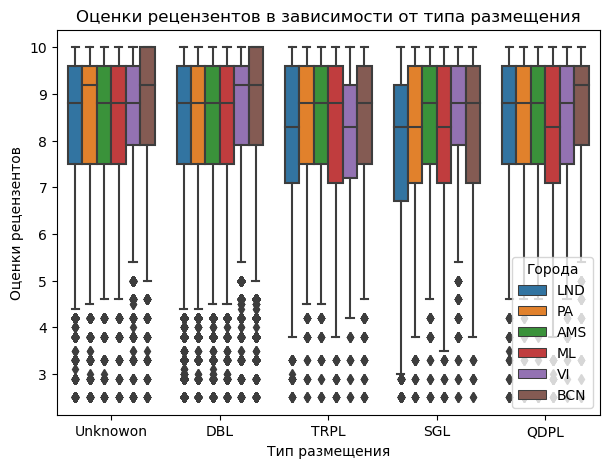

In [156]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='accommodation_type',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от типа размещения')
plt.xlabel('Тип размещения')
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower right',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

## 11.6. Создадим признак room_type
Признак будет содержать информацию о классе номера
- **STD** - Standard
- **SUP** - Superior
- **Suite** - Suite
- **EXEC** - Executive
- **DLX** - Deluxe
- **Unknowon** - информация о классе номера не известна

In [157]:
tags_set = tags_set_copy.copy()

In [158]:
# зададим ключевые слова для нахождения тэгов, относящихся к классу номера
key_words = {
    'classic', 'standard',
    'superior', 'comfort',
    'junior', 'suite',
    'executive', 'deluxe',
}

Создадим список тэгов, подходящих под критерий **Standard (STD)**

In [159]:
filtered_words = {'classic', 'standard'}
# слова, встречающиеся в тэгах, и относящиеся к STD
additional_words = ['basic']
std = tags_filter(filtered_words, key_words, tags_set, additional_words)
#std

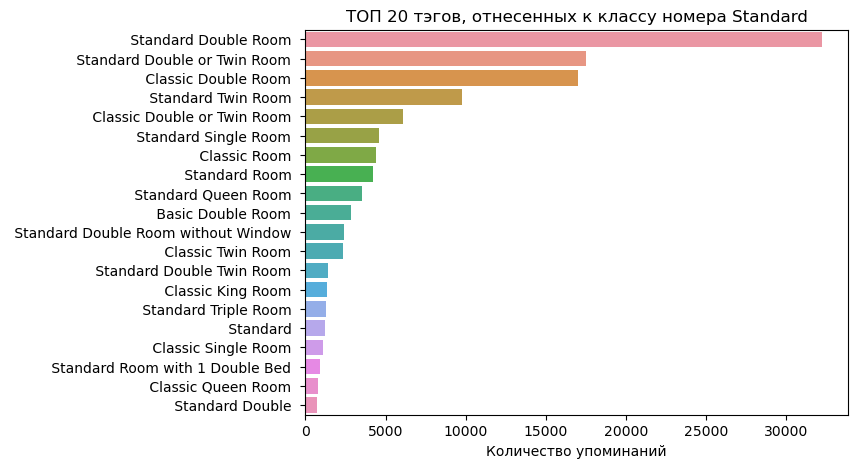

In [160]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(std)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к классу номера Standard')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [161]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(std)
len(tags_set)

2209

Создадим список тэгов, подходящих под критерий **Superior (SUP)**

In [162]:
filtered_words = {'superior', 'comfort'}
# слова, встречающиеся в тэгах, и относящиеся к SUP
#additional_words = []
sup = tags_filter(filtered_words, key_words, tags_set)
#sup

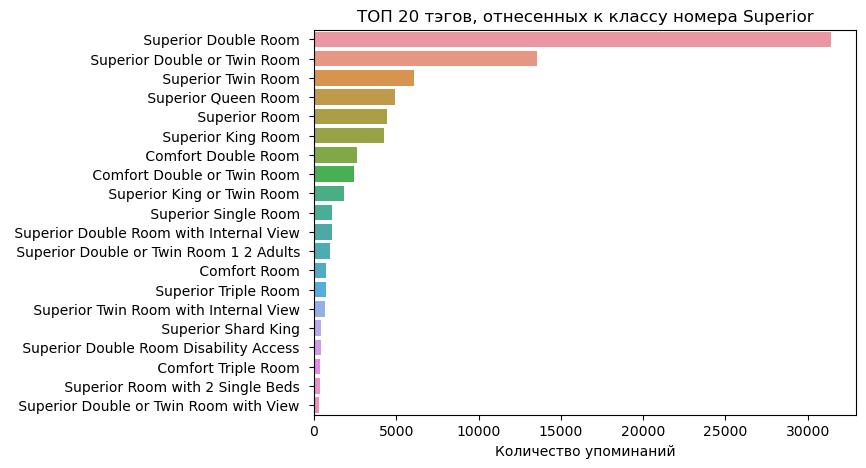

In [163]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(sup)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к классу номера Superior')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [164]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(sup)
len(tags_set)

1897

Создадим список тэгов, подходящих под критерий **Suite (Suite)**

In [165]:
filtered_words = {'junior', 'suite', 'standard'}
# слова, встречающиеся в тэгах, и относящиеся к Suit
#additional_words = []
suite = tags_filter(filtered_words, key_words, tags_set)
#suit

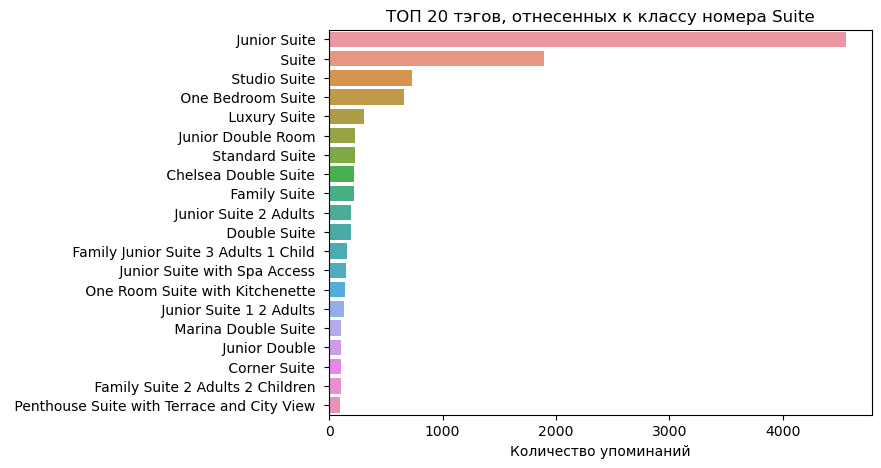

In [166]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(suite)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к классу номера Suite')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [167]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(suite)
len(tags_set)

1452

Создадим список тэгов, подходящих под критерий **Executive (EXEC)**

In [168]:
filtered_words = {'executive'}
# слова, встречающиеся в тэгах, и относящиеся к EXEC
#additional_words = []
executive = tags_filter(filtered_words, key_words, tags_set)
#executive

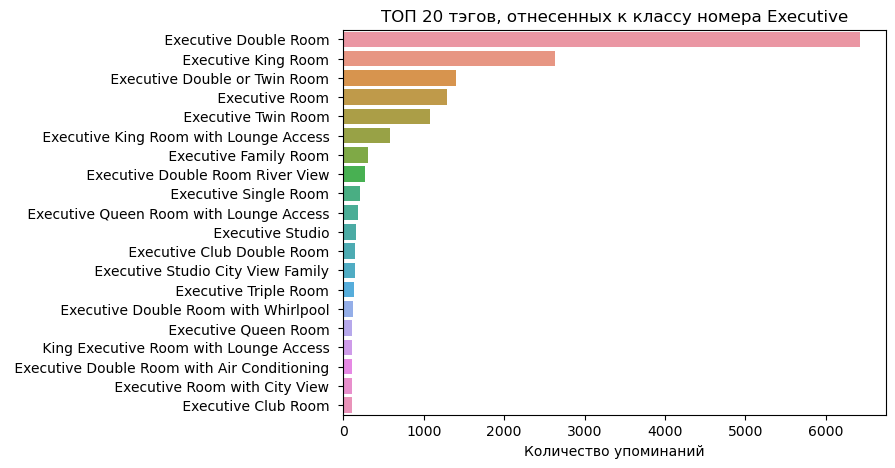

In [169]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(executive)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к классу номера Executive')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [170]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(executive)
len(tags_set)

1282

Создадим список тэгов, подходящих под критерий **Deluxe (DLX)**

In [171]:
filtered_words = {'deluxe', 'standard'}
# слова, встречающиеся в тэгах, и относящиеся к DLX
additional_words = ['luxary']
dlx = tags_filter(filtered_words, key_words, tags_set, additional_words)
#dlx

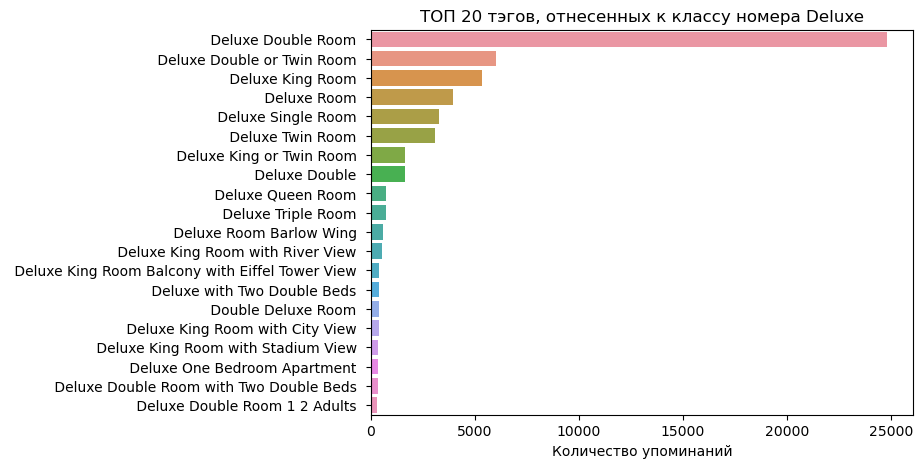

In [172]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(
    data=tags_df[
        tags_df['tags'].isin(dlx)
    ].sort_values(by='sample', ascending=False)[:20],
    x='sample',
    y='tags',
)
plt.title('ТОП 20 тэгов, отнесенных к классу номера Deluxe')
plt.xlabel('Количество упоминаний')
plt.ylabel('')
plt.show()

In [173]:
# удалим из списка обработанные тэги
tags_set = tags_set.difference(dlx)
len(tags_set)

1012

In [174]:
data['room_type'] = data['tags'].apply(
    lambda x: 'STD'
    if x.intersection(std)
    else ('SUP'
          if x.intersection(sup)
          else ('Suite'
                if x.intersection(suite)
                else ('DLX'
                      if x.intersection(dlx)
                      else ('EXEC'
                           if x.intersection(executive)
                           else 'Unknowon'
                           )
                     )
               )
         )
)

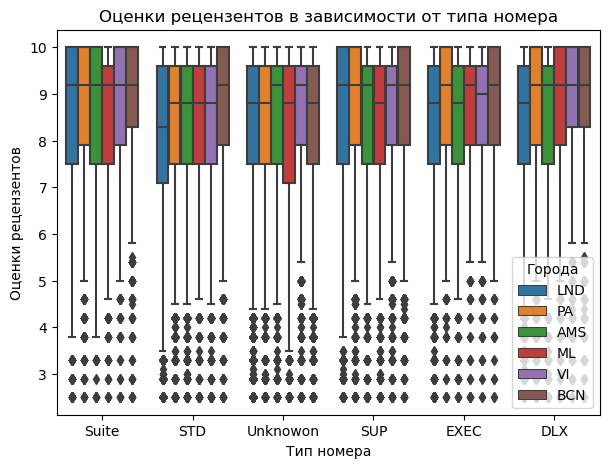

In [175]:
plt.figure(figsize=(7,5), dpi=100)
sns.boxplot(
    data=data.query('sample == 1'),
    x='room_type',
    y='reviewer_score',
    hue='hotel_city'
)
plt.title('Оценки рецензентов в зависимости от типа номера')
plt.xlabel('Тип номера')
plt.ylabel('Оценки рецензентов')
plt.legend(
    loc='lower right',
    title='Города'
)
plt.show()

Видим, что ширина усов, коробок и медианное значение оценок различаются.

In [176]:
# добавим tags в список на удаление из финального датасета
drop_list.extend(['tags'])

# 12. Рассмторим признак **days_since_review**

In [177]:
data['days_since_review'].head(3)

0    13 days
1    234 day
2    616 day
Name: days_since_review, dtype: object

Преобразуем признак, оставив лишь числовую часть данных

In [178]:
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split(' ')[0])
)

# 13. Кодирование признаков

Удалим признаки внесенные в **drop_list**

In [179]:
#drop_list

In [180]:
data.drop(drop_list, axis=1, inplace=True)

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   hotel_city                                  515738 non-null  object 
 

In [182]:
# Определим список категориальных признаков и методы их кодирования
# Для призников, уникальных значений которых менее 15 используем
# One Hot Encoding, в остальных случаях Binary Encoding
categorical_columns = {
    'hotel_city':'OneHotEncoding',
    'hotel_borough':'BinaryEncoding',
    'distance_level':'OrdinalEncoding',
    'review_year':'OneHotEncoding',
    'review_month':'OneHotEncoding',
    'review_dayofweek':'OneHotEncoding',
    'sub_region':'BinaryEncoding',
    'trip_purpose':'OneHotEncoding',
    'trip_type':'OneHotEncoding',
    'number_of_nights':'OrdinalEncoding',
    'accommodation_type':'OneHotEncoding',
    'room_type':'OneHotEncoding'
}

In [183]:
# Определим список бинарных признаков
binary_columns = [
    #'sample', # признак для разделения датасета
    'hotel_network',
    'local_reviewer',
    'empty_negative_review',
    'empty_positive_review',
    'mobile_device'
]

In [184]:
# Определим спиок числовых признаков
digital_columns = [
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    #'reviewer_score', # целевой признак
    'distance',
    'words_difference_in_negative_review',
    'negative_review_neg',
    'negative_review_neu',
    'negative_review_pos',
    'negative_review_compound',
    'words_difference_in_positive_review',
    'positive_review_neg',
    'positive_review_neu',
    'positive_review_pos',
    'positive_review_compound'
]

## 13.1. Кодирование категориальных признаков

In [185]:
for column, encoding_type in categorical_columns.items():
    # метод OneHotEncoding
    if encoding_type is 'OneHotEncoding':
        data = pd.get_dummies(data, columns=[column])
    # мтод BinaryEncoding
    elif encoding_type is 'BinaryEncoding':
        bin_encoder = ce.BinaryEncoder(cols=[column])
        type_bin = bin_encoder.fit_transform(data[column])
        data = pd.concat([data, type_bin], axis=1)
        data.drop(column, axis=1, inplace=True)

Посмотрим на корреляцию признаков

In [186]:
categorical = set(data.columns).difference(set(digital_columns))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning:

overflow encountered in long_scalars



<AxesSubplot:>

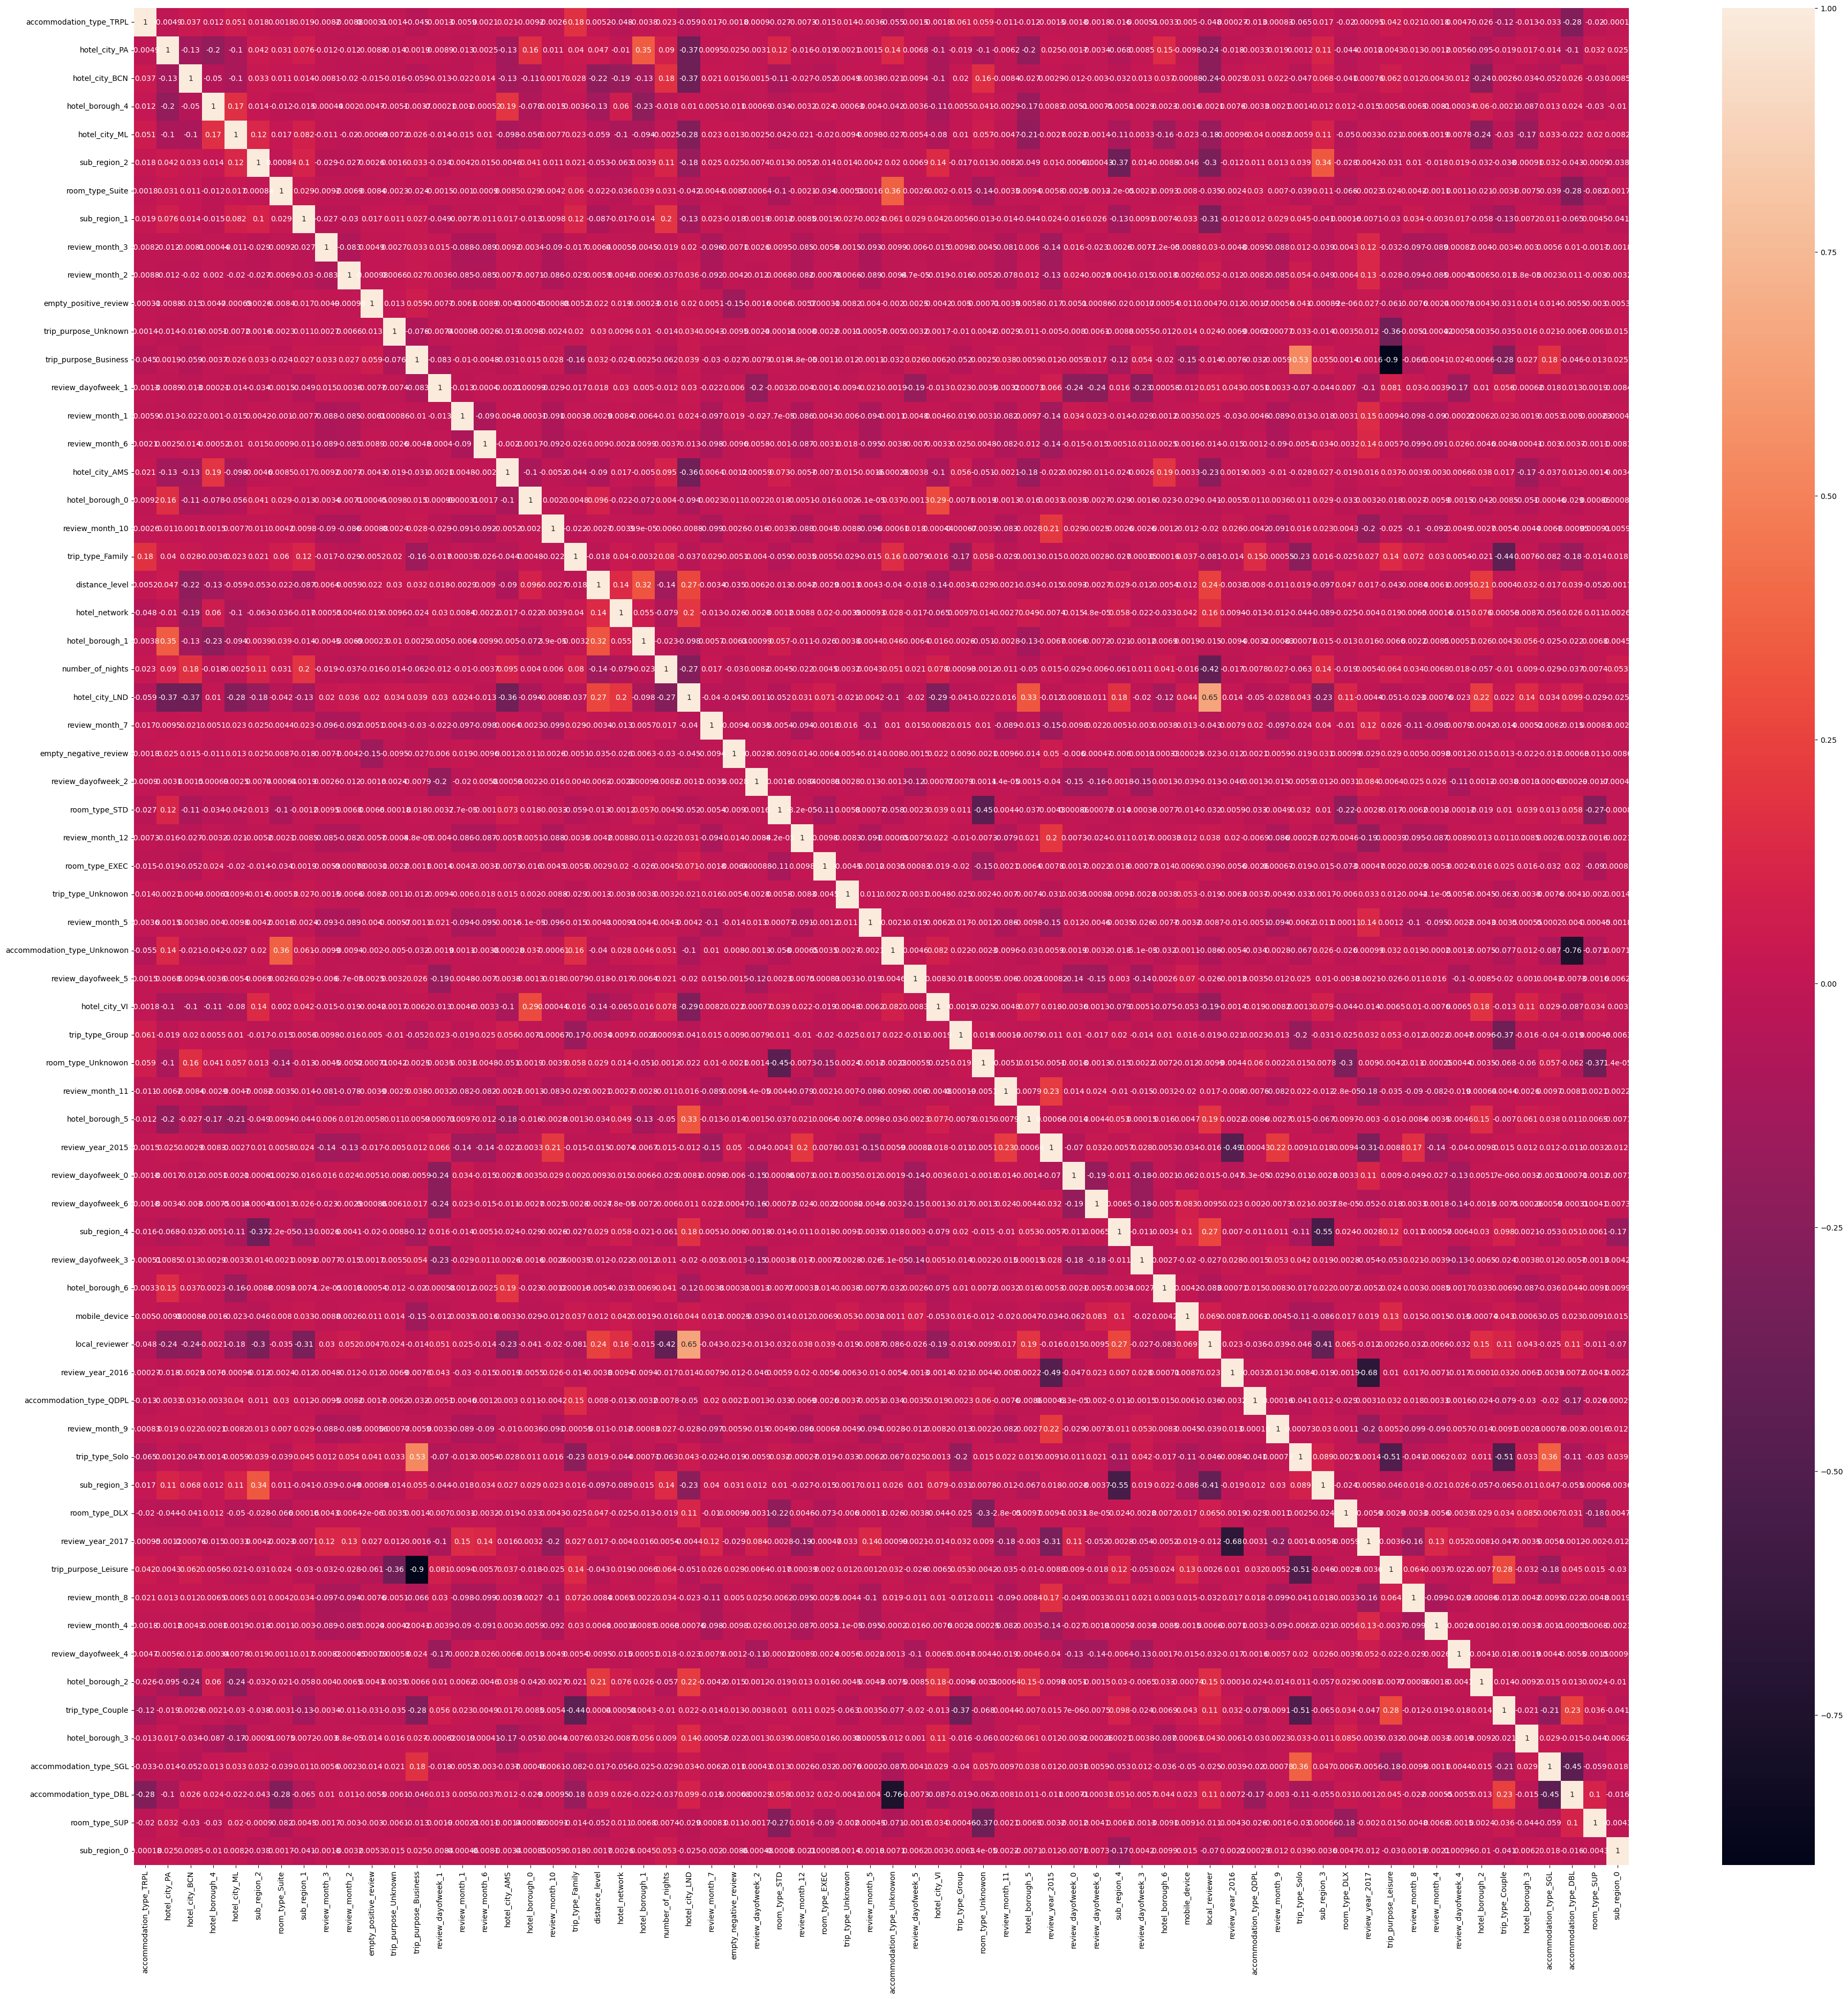

In [187]:
plt.rcParams['figure.figsize'] = (45,45)
sns.heatmap(
    (data[categorical]).drop(
        ['reviewer_score', 'sample'], axis=1
    ).corr(method = 'kendall'),
    annot=True
)

## 13.2. Нормализация и стандартизация числовых признаков
Посмторим на распределения числовых признаков

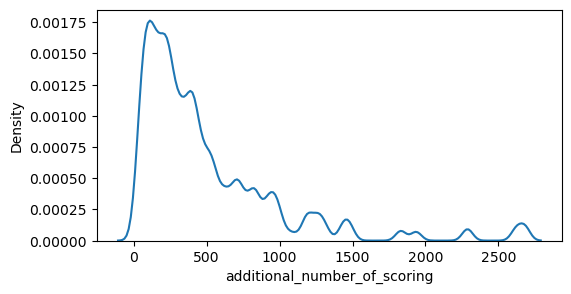

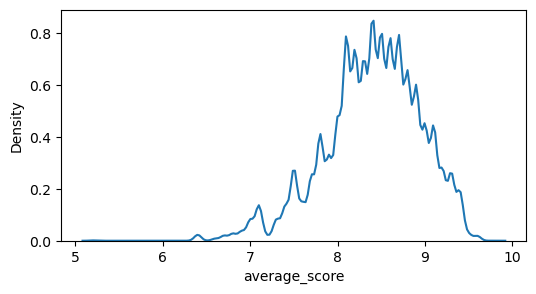

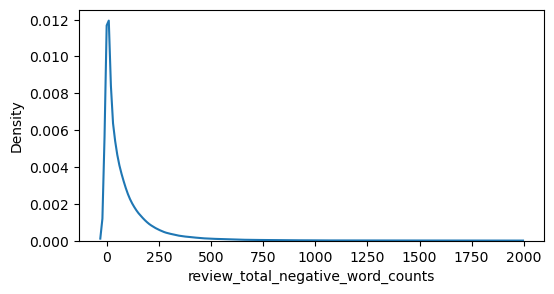

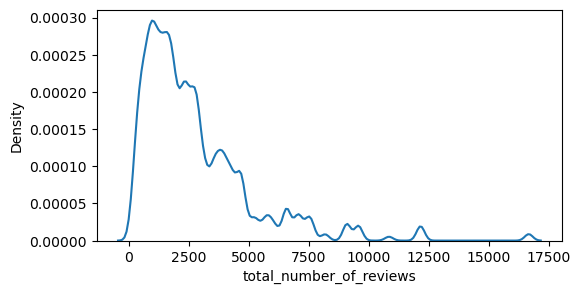

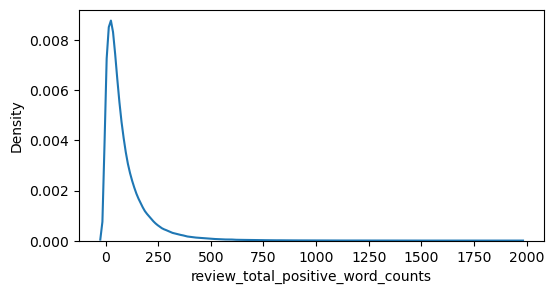

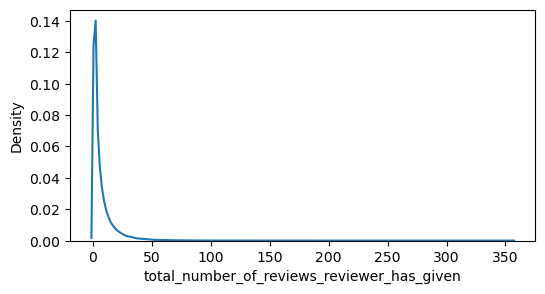

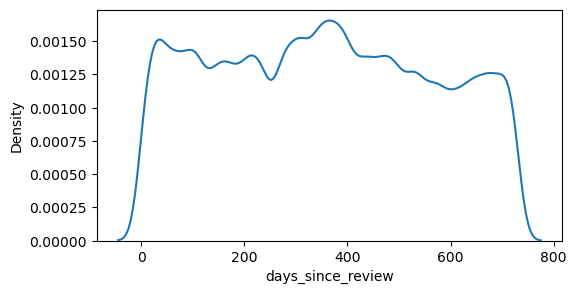

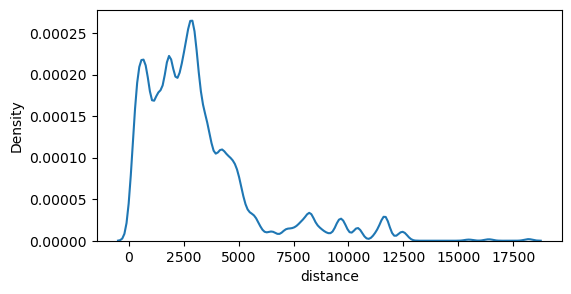

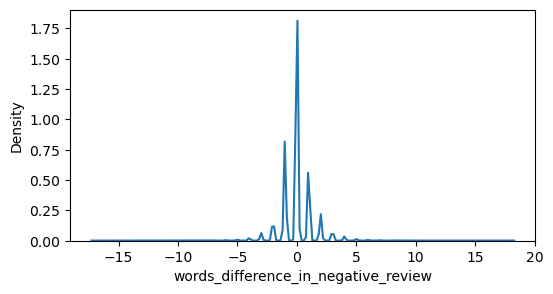

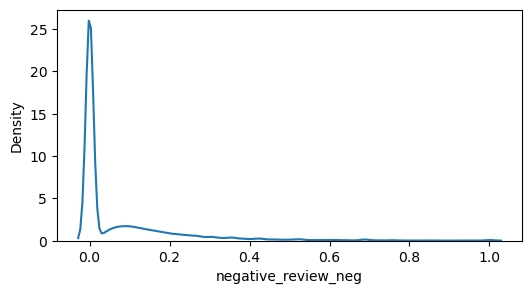

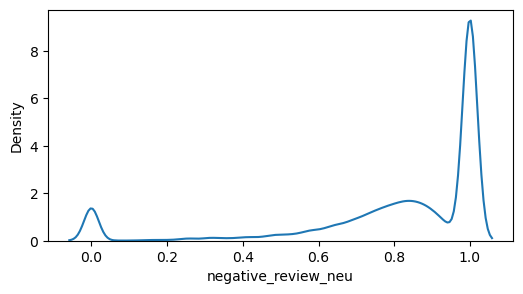

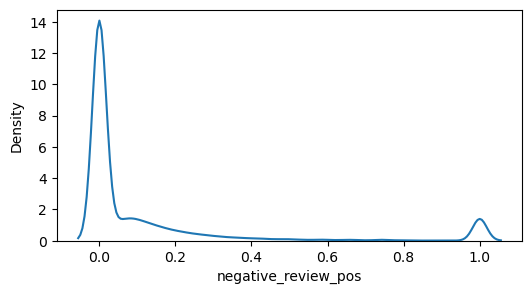

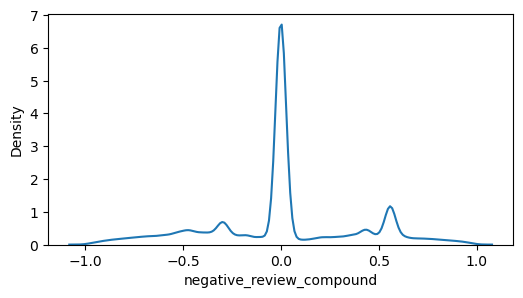

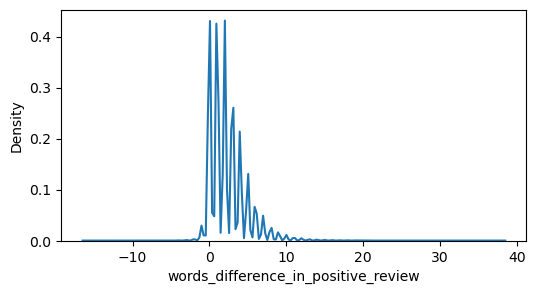

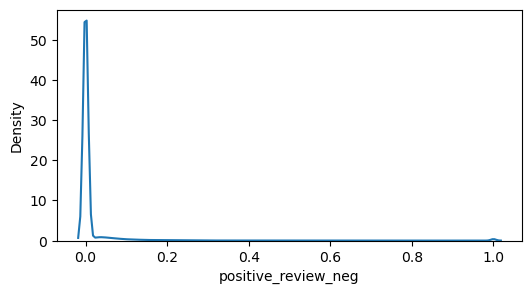

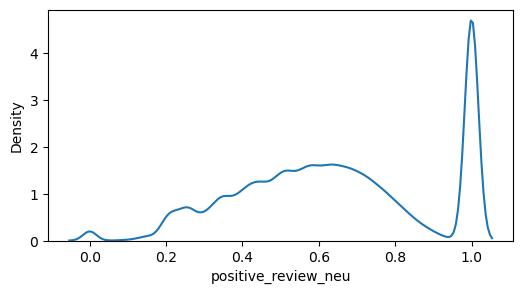

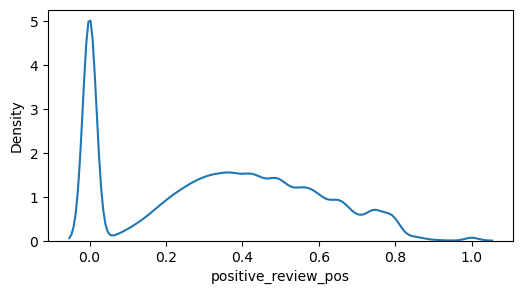

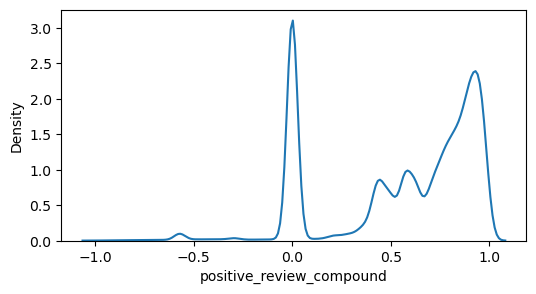

In [188]:
for column in digital_columns:
    plt.subplots(figsize=(6, 3))
    sns.kdeplot(data[column], label=column)
    plt.show()

Нормализуем быбранные признаки методом **RobustScaler**

In [189]:
normalization_list = [
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'distance',
    'words_difference_in_negative_review',
    'words_difference_in_positive_review'
]

r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(data[normalization_list])
df_r = pd.DataFrame(df_r, columns=[normalization_list])

for column in normalization_list:
    data[column] = df_r[column]

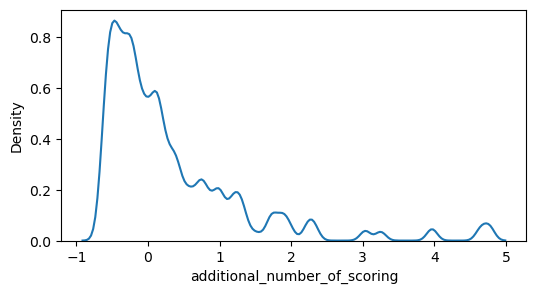

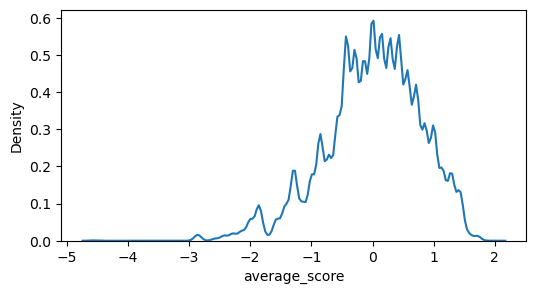

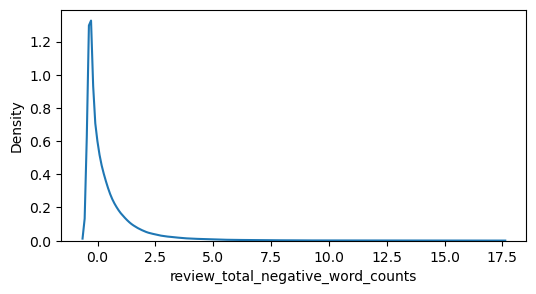

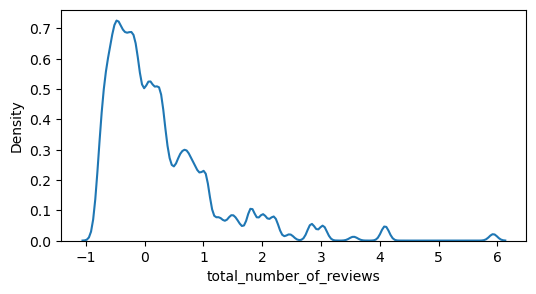

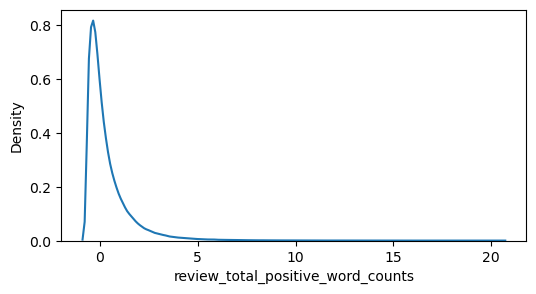

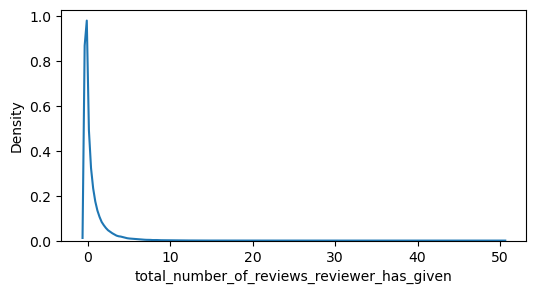

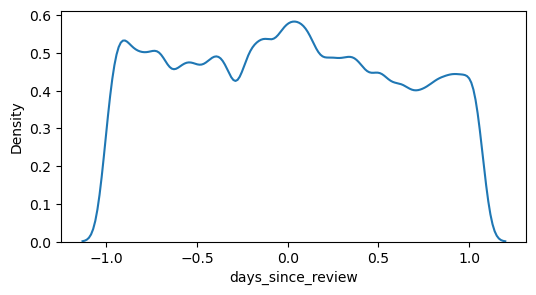

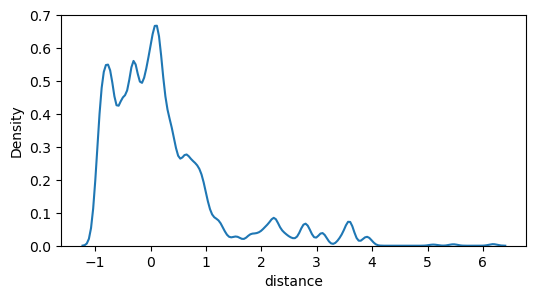

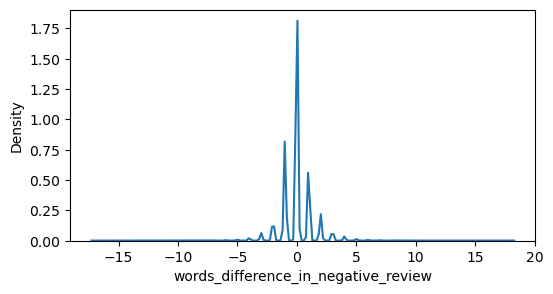

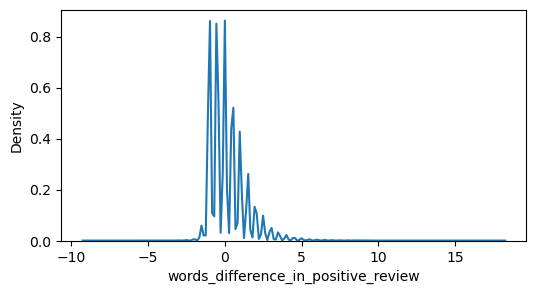

In [190]:
for column in normalization_list:
    plt.subplots(figsize=(6, 3))
    sns.kdeplot(data[column], label=column)
    plt.show()

<AxesSubplot:>

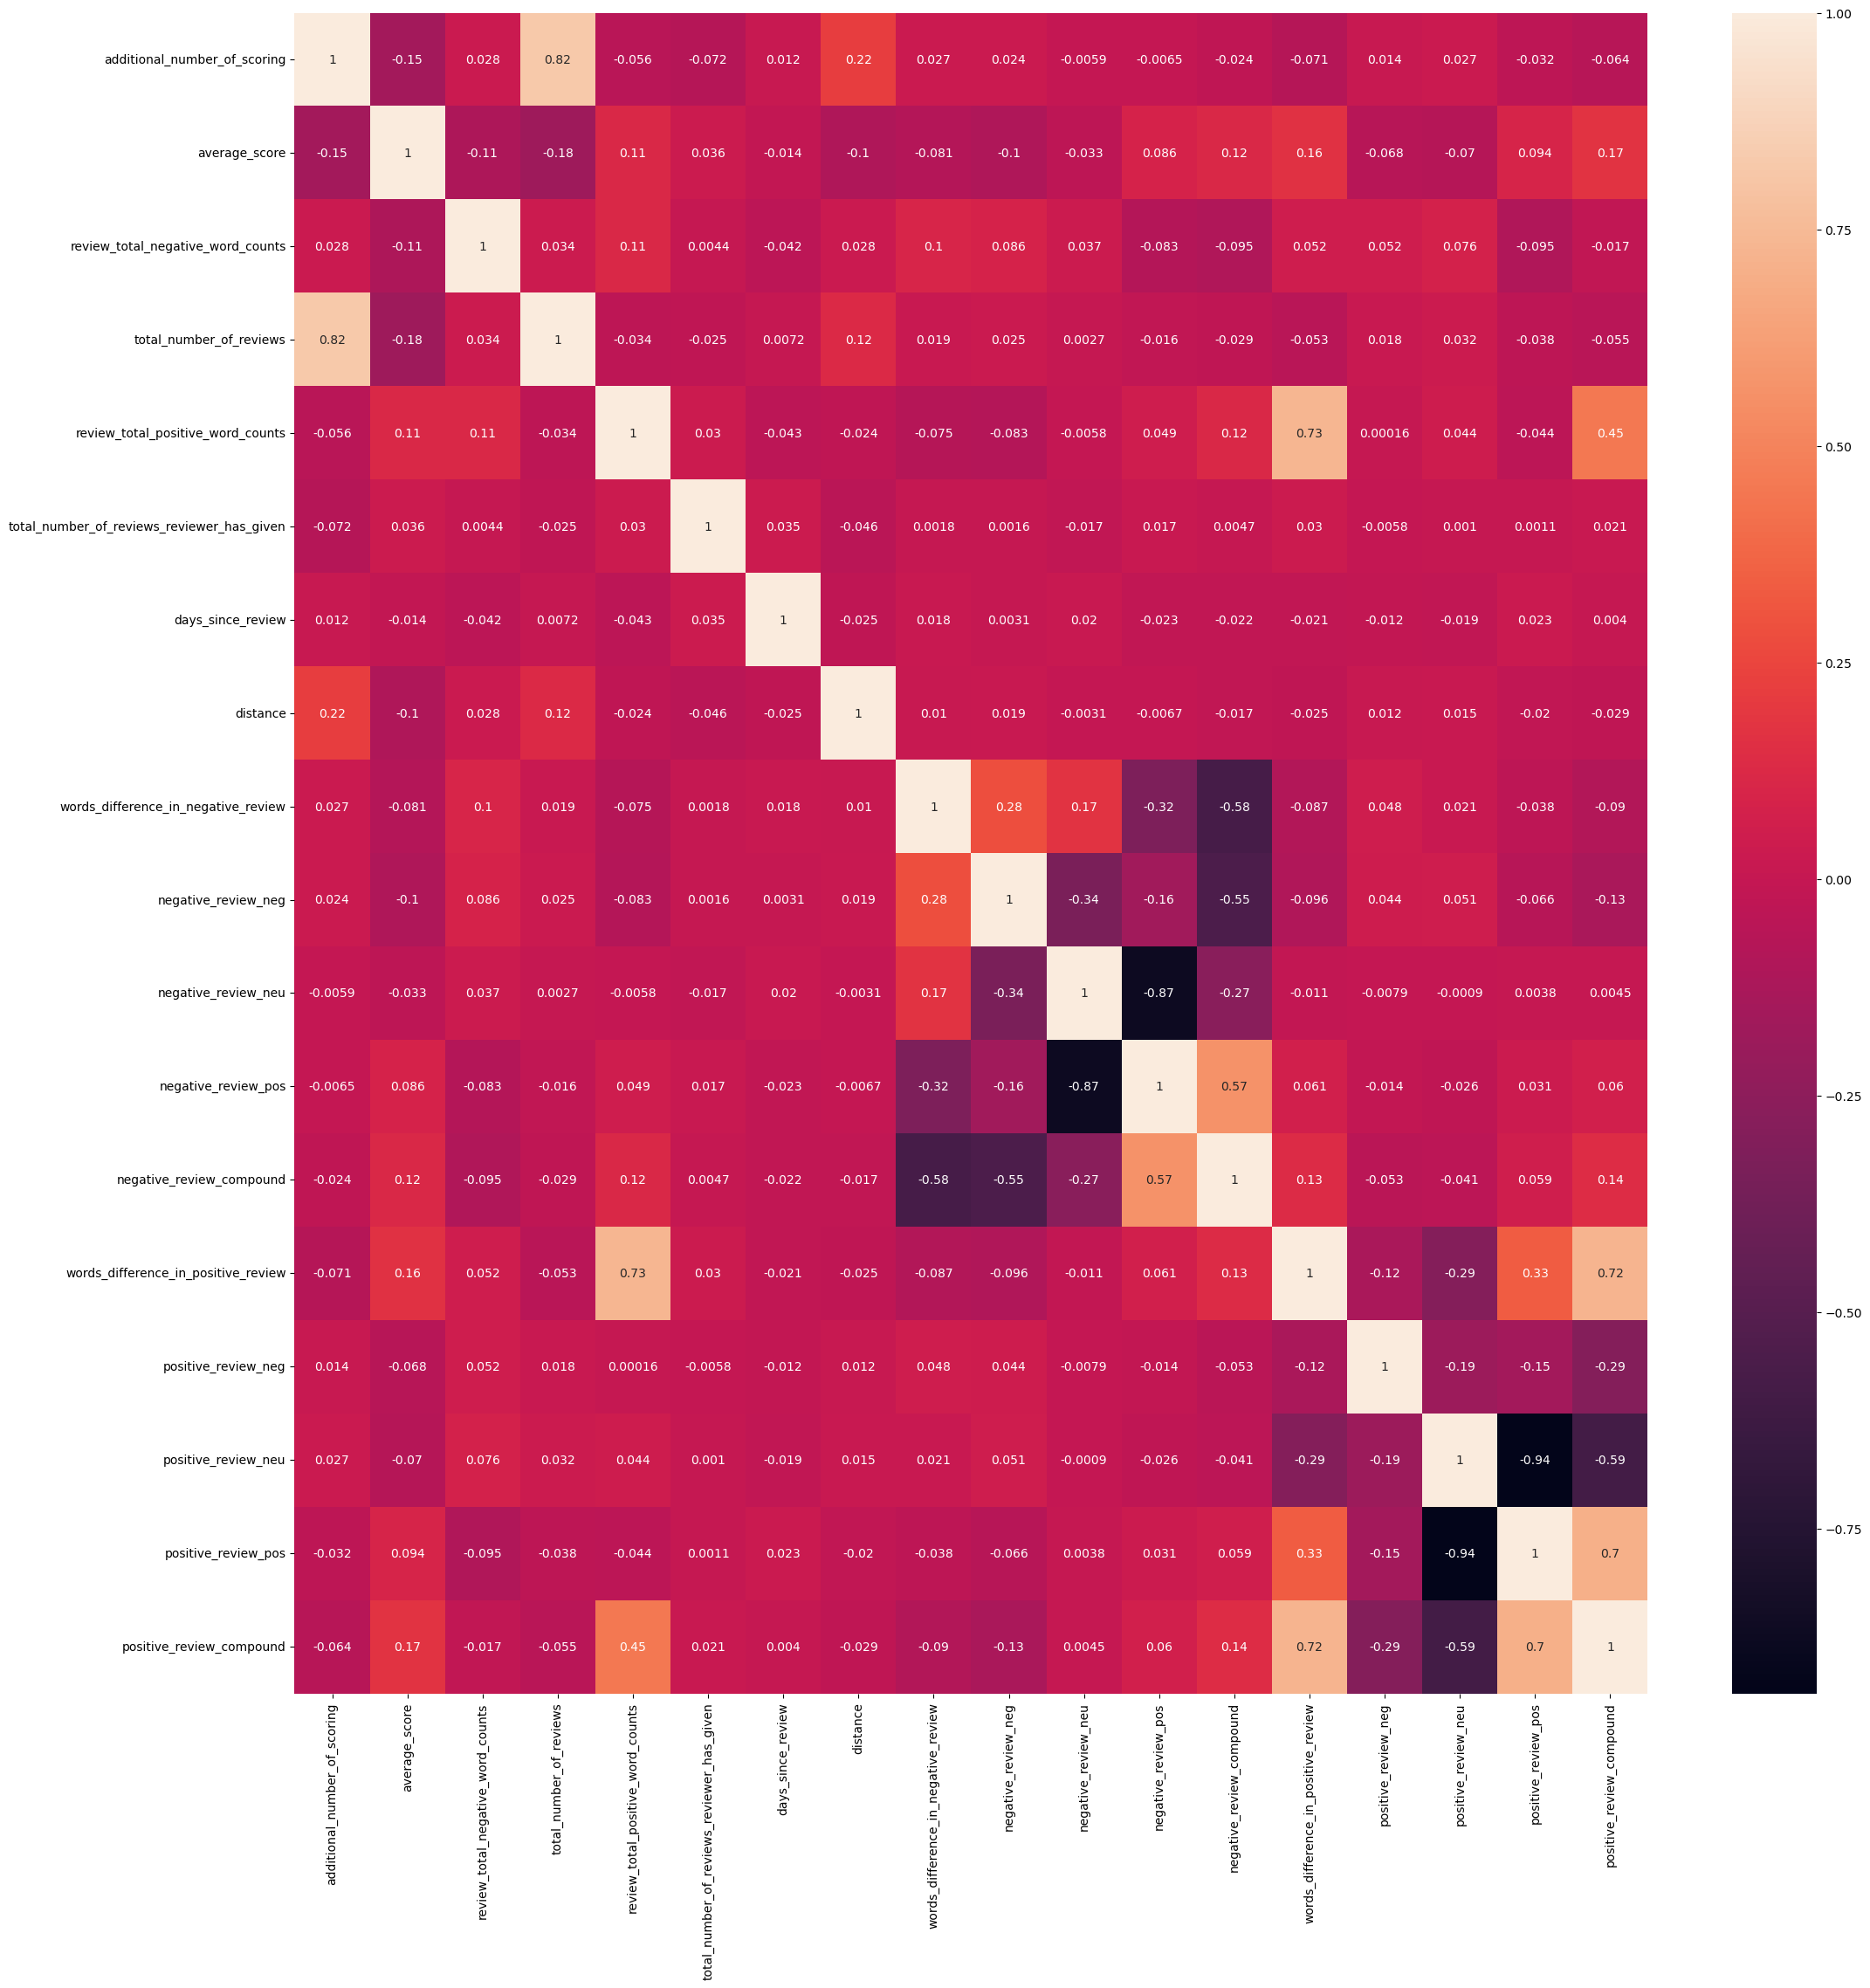

In [191]:
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap((data[digital_columns]).corr(), annot=True)

In [192]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [193]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [194]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 85), (386803, 85), (386803, 84), (290102, 84), (96701, 84))

In [195]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [196]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [197]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную ошибку в процентах.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100)

MAPE: 12.096682905699152


<AxesSubplot:>

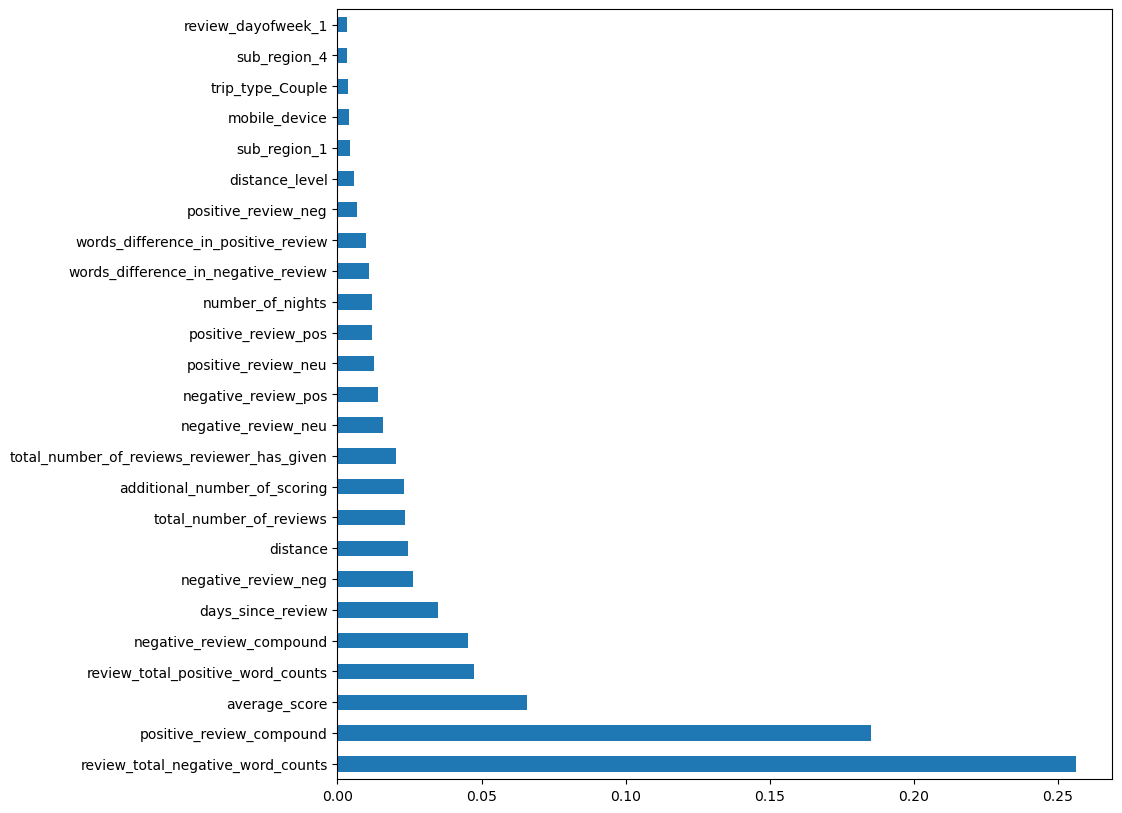

In [198]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [199]:
test_data.sample(10)

additional_number_of_scoring  average_score  \
25300                       1.352342      -0.142857   
61580                       0.099796      -1.142857   
124331                     -0.641548      -4.571429   
115284                      0.048880      -0.142857   
35653                       0.099796      -1.142857   
52762                       0.134420      -1.571429   
123503                     -0.305499       0.857143   
87196                      -0.429735       0.142857   
30972                      -0.317719       1.428571   
69619                      -0.152749       0.000000   

        review_total_negative_word_counts  total_number_of_reviews  \
25300                            0.099099                 0.544454   
61580                            0.216216                 1.024470   
124331                           1.486486                -0.680669   
115284                           1.144144                -0.273654   
35653                           -0.207207                 1.024470   
52762                            0.171171                 0.418842   
123503                          -0.360360                -0.328303   
87196                            0.063063                -0.559543   
30972                            0.126126                -0.321778   
69619                           -0.171171                -0.383768   

        review_total_positive_word_counts  \
25300                            0.150538   
61580                            1.967742   
124331                          -0.322581   
115284                          -0.268817   
35653                           -0.215054   
52762                           -0.322581   
123503                           0.903226   
87196                            0.236559   
30972                            0.612903   
69619                           -0.215054   

        total_number_of_reviews_reviewer_has_given  days_since_review  \
25300                                     1.285714          -0.508523   
61580                                     1.000000           1.053977   
124331                                    0.571429          -0.625000   
115284                                    0.000000          -0.497159   
35653                                     0.000000           0.230114   
52762                                    -0.285714           0.928977   
123503                                   -0.285714           1.000000   
87196                                     0.142857           0.150568   
30972                                     0.142857          -0.954545   
69619                                    -0.285714           0.215909   

        reviewer_score  distance  distance_level  ...  \
25300              0.0  3.642744              11  ...   
61580              0.0 -0.063838               5  ...   
124331             0.0 -0.441316               3  ...   
115284             0.0  0.108644               6  ...   
35653              0.0 -0.063838               5  ...   
52762              0.0  0.923077              10  ...   
123503             0.0 -0.339413               4  ...   
87196              0.0 -0.235924               5  ...   
30972              0.0 -0.032910               6  ...   
69619              0.0 -0.572165               3  ...   

        accommodation_type_QDPL  accommodation_type_SGL  \
25300                         0                       0   
61580                         0                       0   
124331                        0                       0   
115284                        0                       0   
35653                         0                       0   
52762                         1                       0   
123503                        0                       0   
87196                         0                       0   
30972                         0                       0   
69619                         0                       0   

        accommodation_type_TRPL  accommodation_type_U

In [200]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [201]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [202]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [203]:
predict_submission

array([8.472, 7.531, 8.89 , ..., 7.936, 9.589, 7.177])

In [204]:
list(sample_submission)

['reviewer_score', 'id']

In [205]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.472  488440
1           7.531  274649
2           8.890  374688
3           9.690  404352
4           9.657  451596
5           8.784  302161
6           7.955  317079
7           7.714   13963
8           8.604  159785
9           7.192  195089

# Выводы
В результате проделанной работы можно сделать несколько выводов:

1. Первое и основное - нужно внимательно изучать кажды признак датасета, как по отдельности так и в связки с другими признаками, при этом нужно отслеживать поведение целевого признака. 
2. Поиск инофрмации на сторонних ресурсах может значительно упростить работу над анализом, обработкиой и созданием признаков.
3. Текстовы данные содержать очень много полезной информации, но обрабатывать их нетривиальная задача. Поиск ключевых слов, создание тематических групп и особенно семантический анализ текса .. это все очень интерессные задачи, которые заняли значительную часть времени работы на проектом. 
4. Удаление коррелированных признаков может ухудшить точность модели.
5. Нормализация данных может не влиять на работу модели и ее точность.

Самыми значимыми признаками при обучении модели оказались отрицательный и положительный отзыв, а так же все признаки, спроектированные на их основе.

Уверен, что из отзывов можно вытащить большое количество информации, на основе которой будут созданы весомые для модели признаки и полученный мною результат можно значительно улучшить. Данная работа заняла у меня порядка 20 дней, и несмотря на огромный мотивационный эффект соревнования, пожалуй, остановлюсь на текущем результате.